In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import signal
import os
import glob
%matplotlib inline
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from readTRC import readTrc
from scipy.fftpack import rfft, irfft, fftfreq

In [21]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def find_vals(X,Y,cut):
    dataX = X[cut:]
    dataY = Y[cut:]
    minn = min(dataY)
    sig_val = minn*0.5
    MeanLoc = np.where(dataY==minn)[0][0]
    Mean = dataX[MeanLoc]
    L = dataY[0:MeanLoc]
    R = dataY[MeanLoc:len(dataY)]
    LP =find_nearest(L,sig_val)
    RP =find_nearest(R,sig_val)
    whereL = np.where(L==LP)[0][0]
    whereR = np.where(R==RP)[0][0]
    Lpoint = dataX[whereL]
    Rpoint = dataX[MeanLoc+whereR]
    FWHM = (Rpoint-Lpoint)   
    return (Mean,FWHM)

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [3]:
cd /Users/austinmcdonald/Desktop/data/Ion-stuff/Ion mobilitys/Argon/901018-125-2bar-overnight/

/Users/austinmcdonald/Desktop/data/Ion-stuff/Ion mobilitys/Argon/901018-125-2bar-overnight


In [35]:
files = os.listdir('/Users/austinmcdonald/Desktop/data/Ion-stuff/Ion mobilitys/Argon/901018-125-2bar-overnight/Data')
files = sorted(files)
N = len(files)
Cfiles = np.array_split(files,int(N/200)) # chinks the files

In [12]:
Path = '/Users/austinmcdonald/Desktop/data/Ion-stuff/Ion mobilitys/Argon/901018-125-2bar-overnight/'

In [16]:
X, Y, info = readTrc(Path+'Data/'+files[0])
Name='First-200'
Name='Last-200'

Yvals = np.zeros(X.shape[0])
Xvals = np.zeros(Y.shape[0])
avg = 0
for w in range(N-200,N):
    X, Y, info = readTrc(Path+'Data/'+files[w])
    if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
        Yvals += Y
        Xvals += X
        avg   += 1
Yvals = Yvals/avg
Xvals = Xvals/avg
TriggerTime = find_nearest(Xvals,0)
Trigger     = np.where(Xvals==TriggerTime)[0][0]
baseline    = np.mean(Yvals[0:Trigger])
data = [Xvals,Yvals-baseline]
np.savetxt(Path+Name+'.txt',data)

In [145]:
for q in range(0,len(Cfiles)):
    files = Cfiles[q]
    Name = 'waveform-'+str(q).zfill(3)
    N = len(files)
    
    X, Y, info = readTrc(Path+'Data/'+files[0])
    
    Yvals = np.zeros(X.shape[0])
    Xvals = np.zeros(Y.shape[0])
    avg = 0
    for w in range(0,N):
        X, Y, info = readTrc(Path+'Data/'+files[w])
        if Y.shape[0]==Yvals.shape[0] and X.shape[0]==Xvals.shape[0]:
            Yvals += Y
            Xvals += X
            avg   += 1
    Yvals = moving_average(Yvals/avg,70)
    Xvals = moving_average(Xvals/avg,70)
    
    ''' TriggerTime = find_nearest(Xvals,0)
    Trigger     = np.where(Xvals==TriggerTime)[0][0]
    baseline    = np.mean(Yvals[0:Trigger])'''
    
    T1 = find_nearest(Xvals,.100)
    T1cut = np.where(Xvals==T1)[0][0]
    T2 = find_nearest(Xvals,.400)
    T2cut = np.where(Xvals==T2)[0][0]
    
    baseline    = np.min(Yvals[T1cut:T2cut])
    data = [Xvals,Yvals-baseline]
    np.savetxt(Path+Name+'.txt',data)
    

In [146]:
#PATH = '/Users/austinmcdonald/Desktop/data/Ion-stuff/Ion mobilitys/Argon/090418-cleaned-2bar/'
files = glob.glob('*.txt')
#files.remove('.DS_Store')
files.remove('First-200.txt')
files.remove('Last-200.txt')
files.sort()
files[0]

'waveform-000.txt'

In [147]:
names = []
for q in range(0,len(files)):
    na = files[q].split('.')[0]
    names.append(na)
names[0]

'waveform-000'

In [148]:
ml = 1e3
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
aa = 1
Xvals=dict()
Yvals=dict()
for q in range(0,len(files)):
    Hold = np.loadtxt(files[q])
    Xvals[q] = moving_average(Hold[0]*ml,aa)
    Yvals[q] = moving_average(Hold[1]*ml,aa)

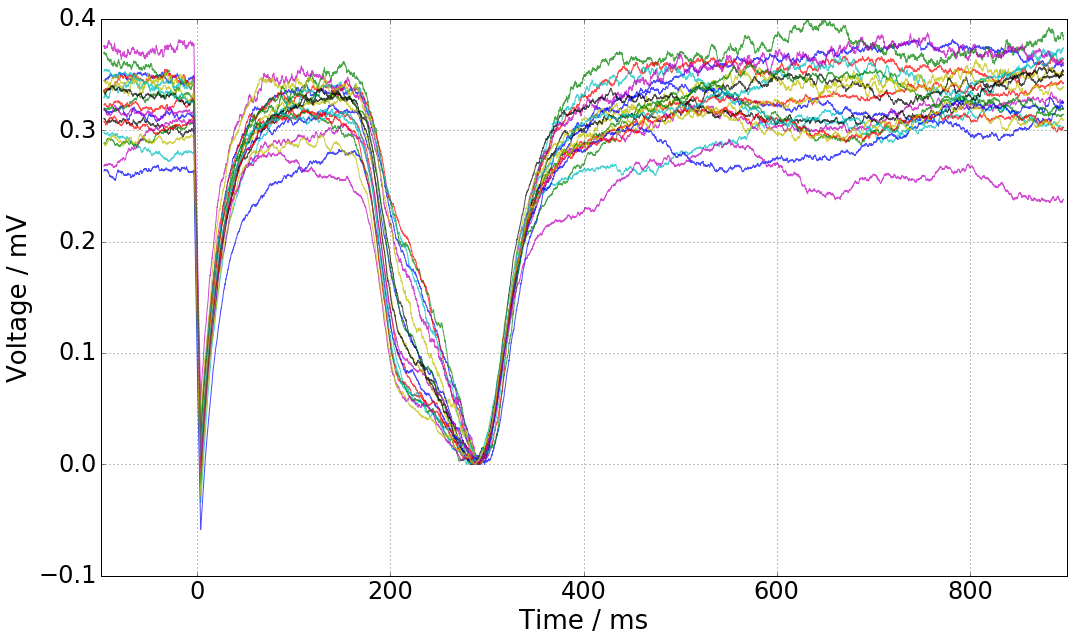

In [149]:
plt.figure(figsize=(15,9))

#for q in range(0,len(Cfiles)):
for q in range(0,20):

    P=21
    PP=3
    XX = Xvals[q]
    YY = Yvals[q]
    plt.plot(XX,YY,label=(names[q]+''+'V/cm'),alpha=0.7)
    
plt.xlim(-.1*ml,900)
#plt.ylim(-0.4,.1)
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltage / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()
#plt.legend(loc='lower right',fontsize=25)
plt.tight_layout()
PPath = Path+'Plots/'+names[q]+'.tif'
#plt.savefig(PPath)
plt.show()

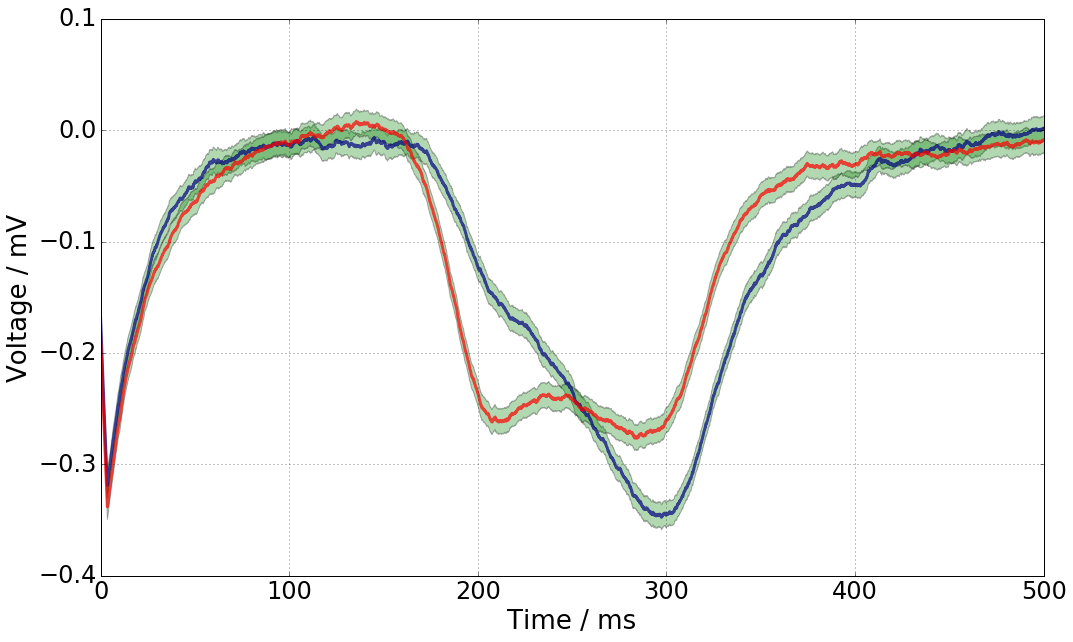

In [130]:
plt.figure(figsize=(15,9))

plt.figure(figsize=(15,9))

XX = Xvals[0]
YY = Yvals[0]


plt.plot(XX,YY,label=(names[q]+''+'V/cm'),alpha=0.7,lw=3,color='navy')
sigma = 0.011238097450219895
y1 = YY-sigma
y2 = YY+sigma
plt.fill_between(XX, y1, y2, facecolor='green', interpolate=True,alpha=0.3)


NNN = len(Xvals)
XX = Xvals[NNN-2]
YY = Yvals[NNN-2]
plt.plot(XX,YY,label=(names[q]+''+'V/cm'),alpha=0.7,lw=3,color='r')
sigma = 0.011238097450219895
y1 = YY-sigma
y2 = YY+sigma
plt.fill_between(XX, y1, y2, facecolor='green', interpolate=True,alpha=0.3)



plt.xlim(0,500)
plt.ylim(-0.4,.1)
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltage / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()
#plt.legend(loc='lower right',fontsize=25)
plt.tight_layout()
#PPath = Path+'Plots/'+names[q]+'.tif'
#plt.savefig(PPath)
plt.show()

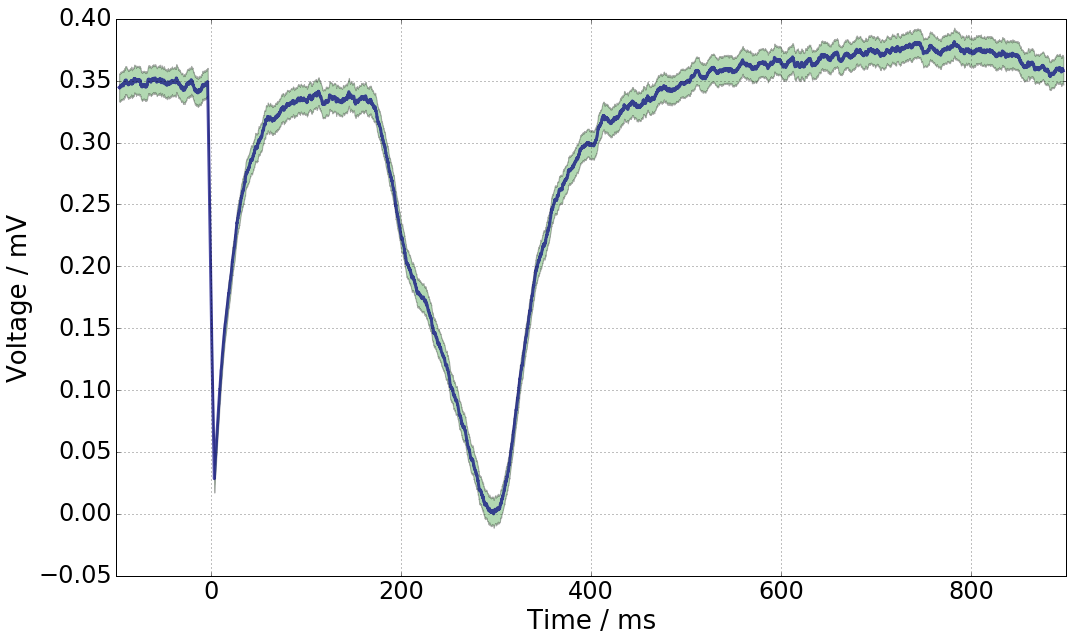

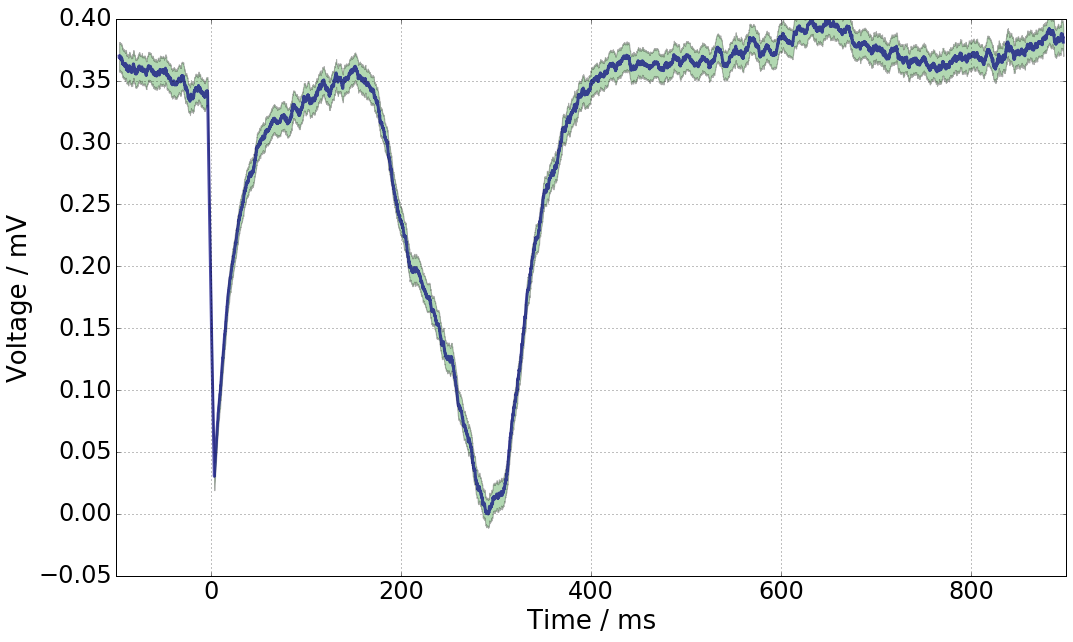

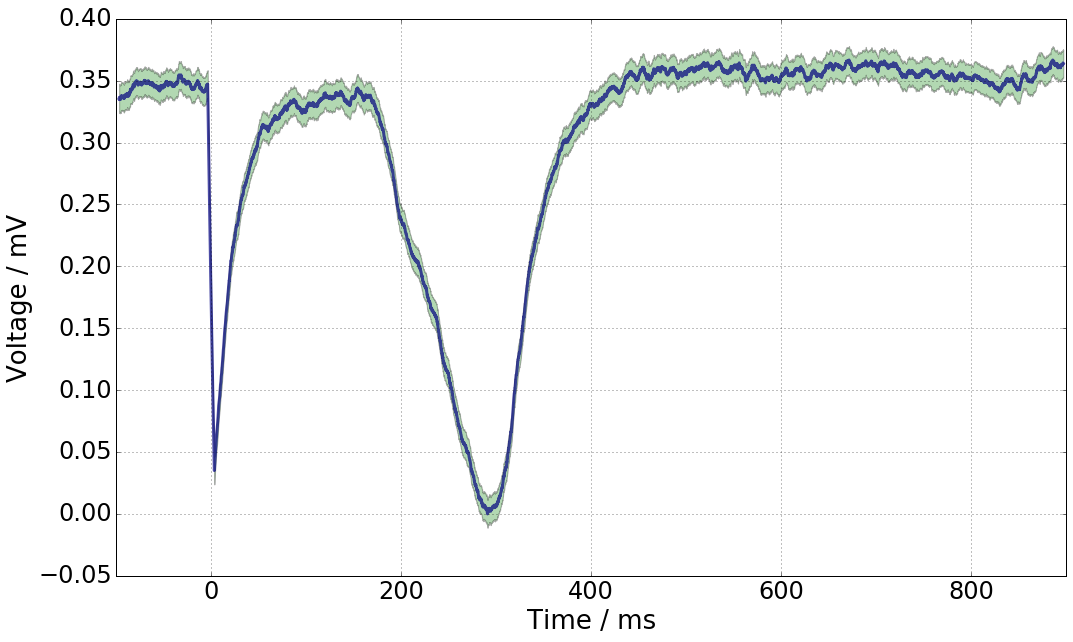

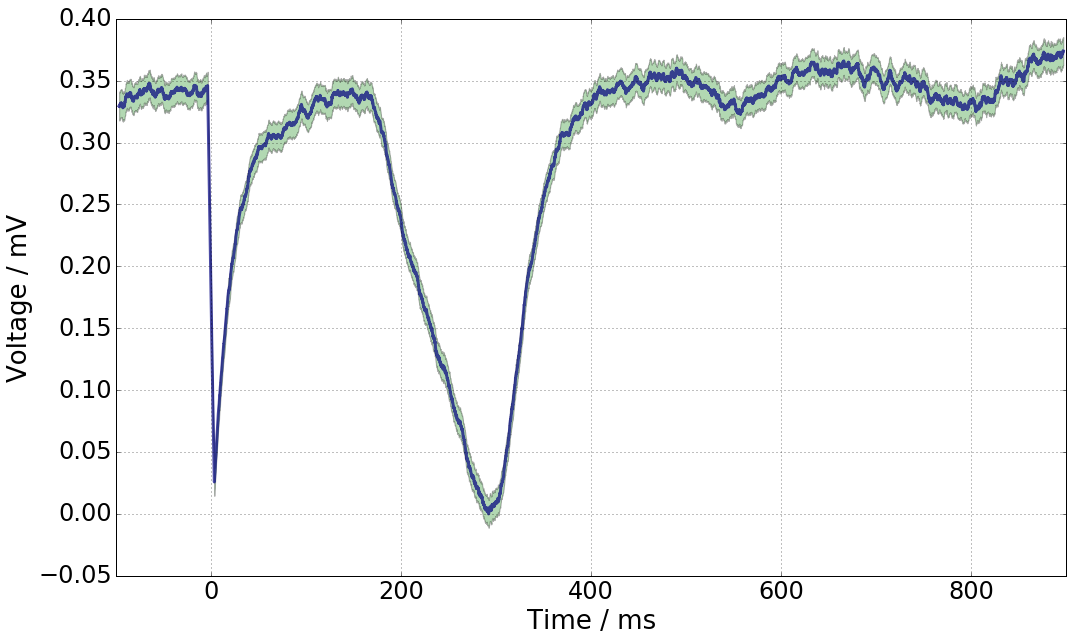

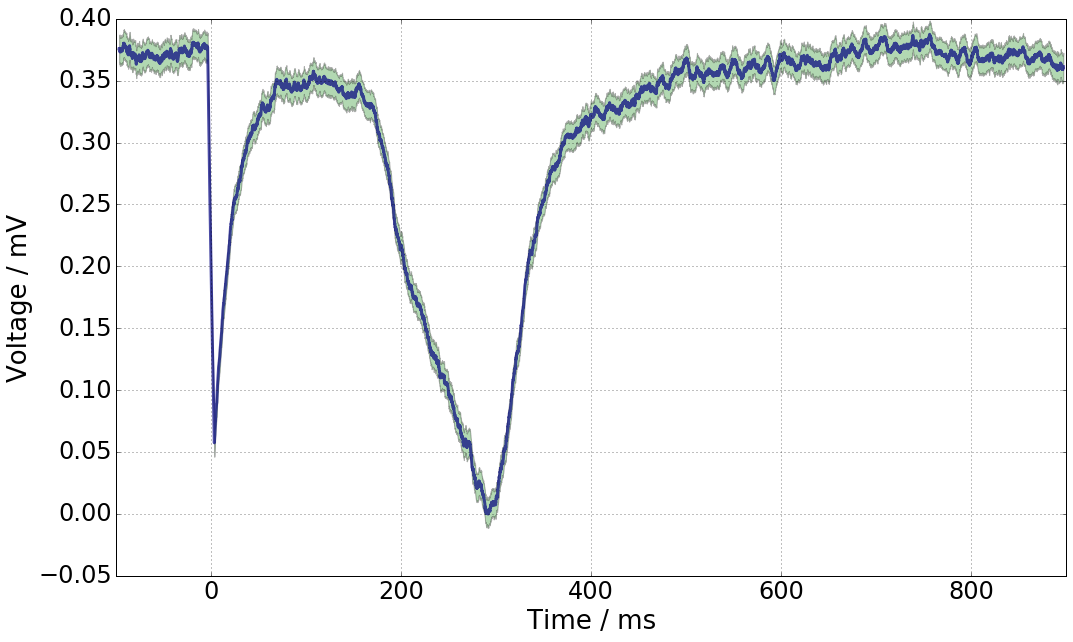

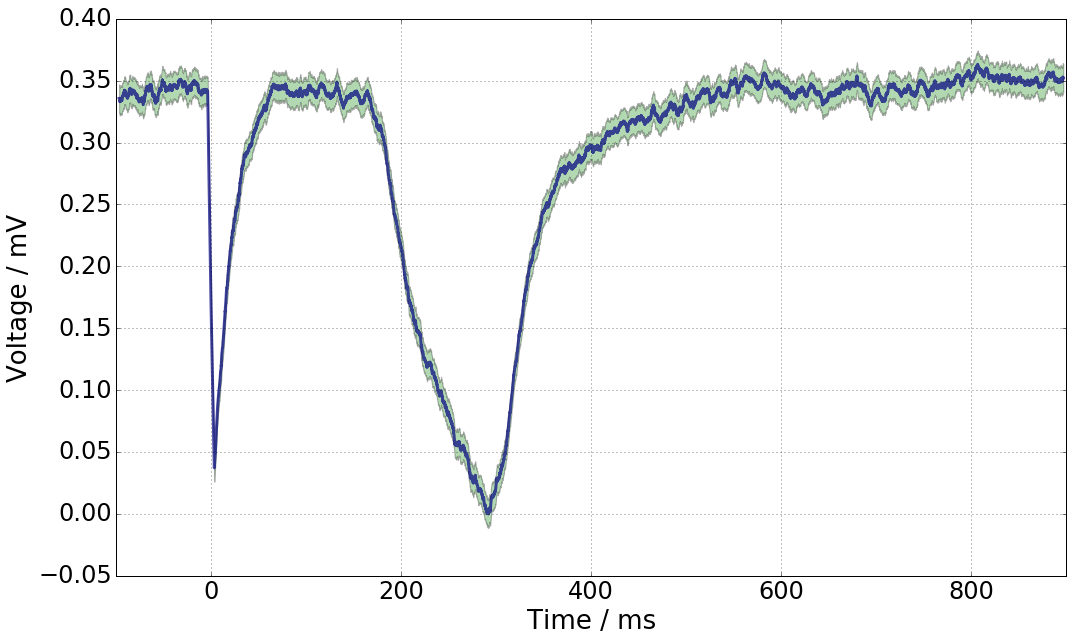

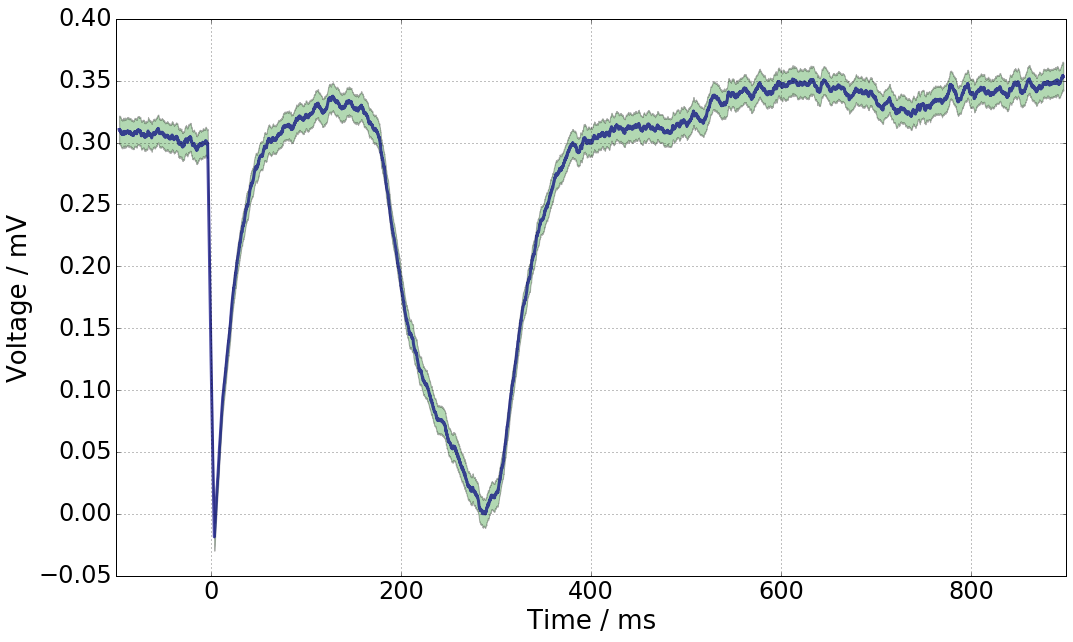

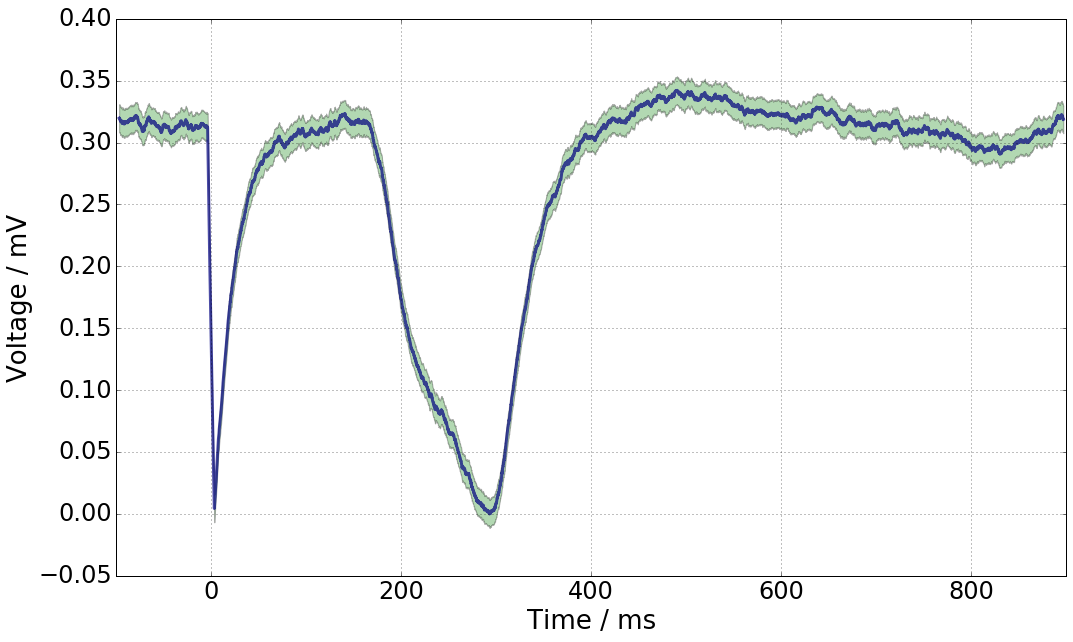

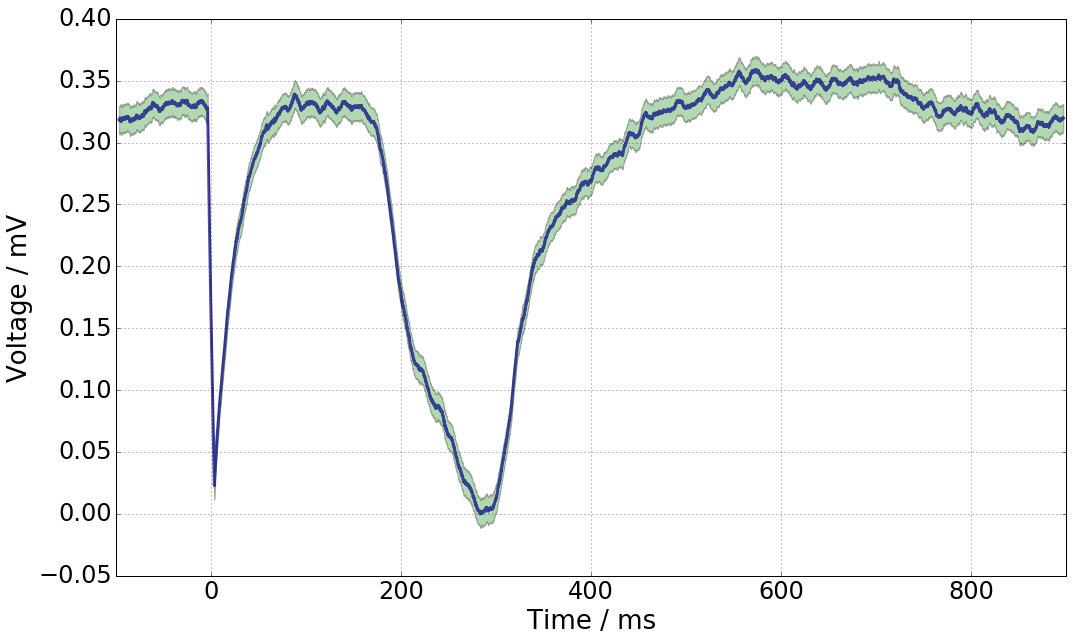

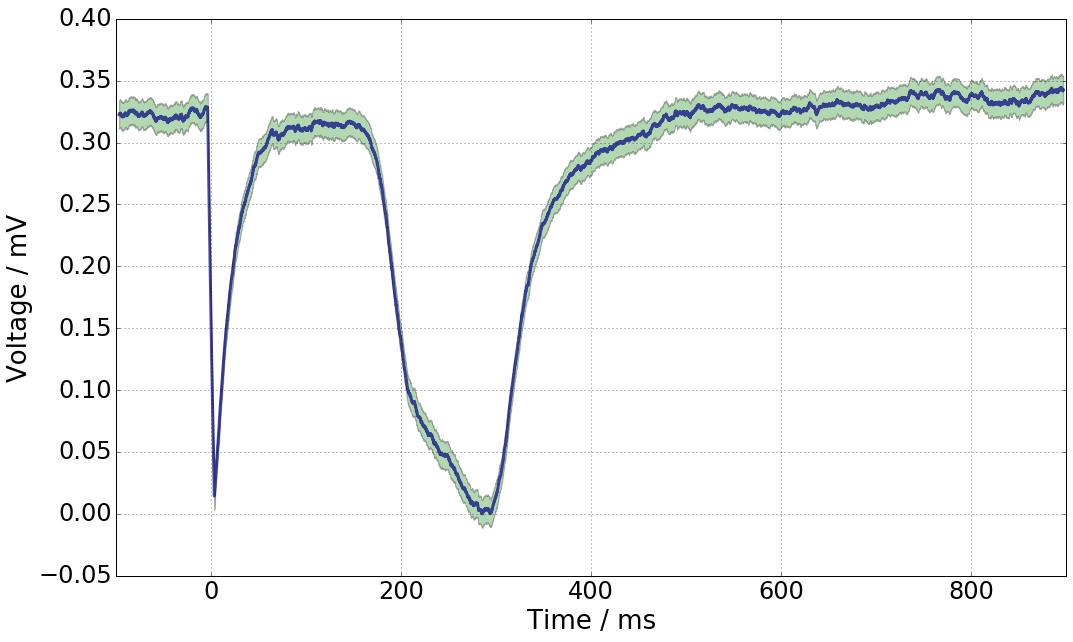

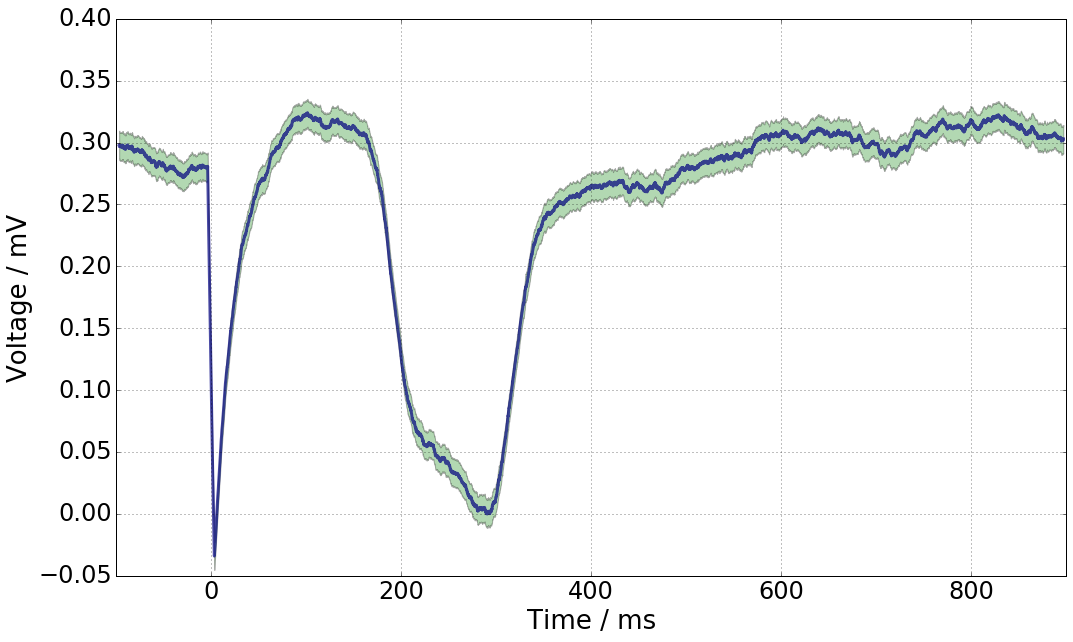

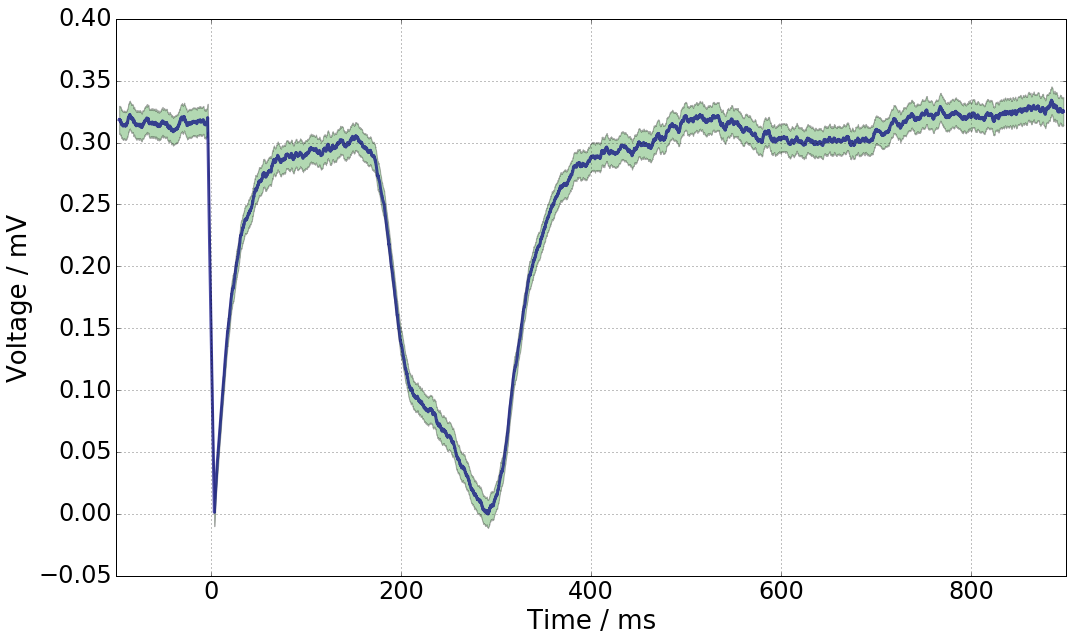

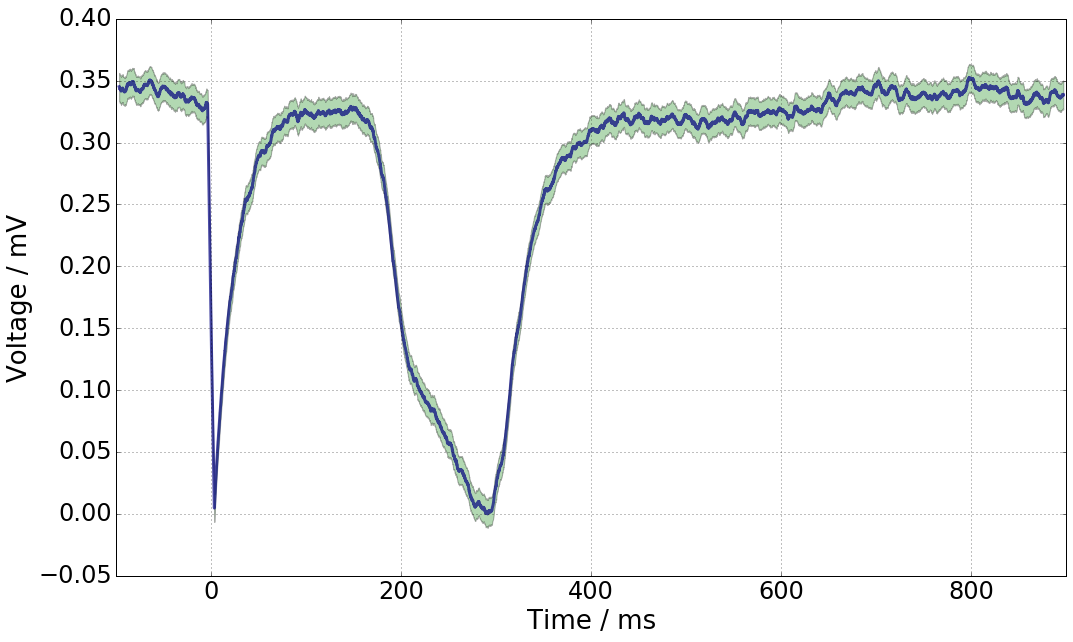

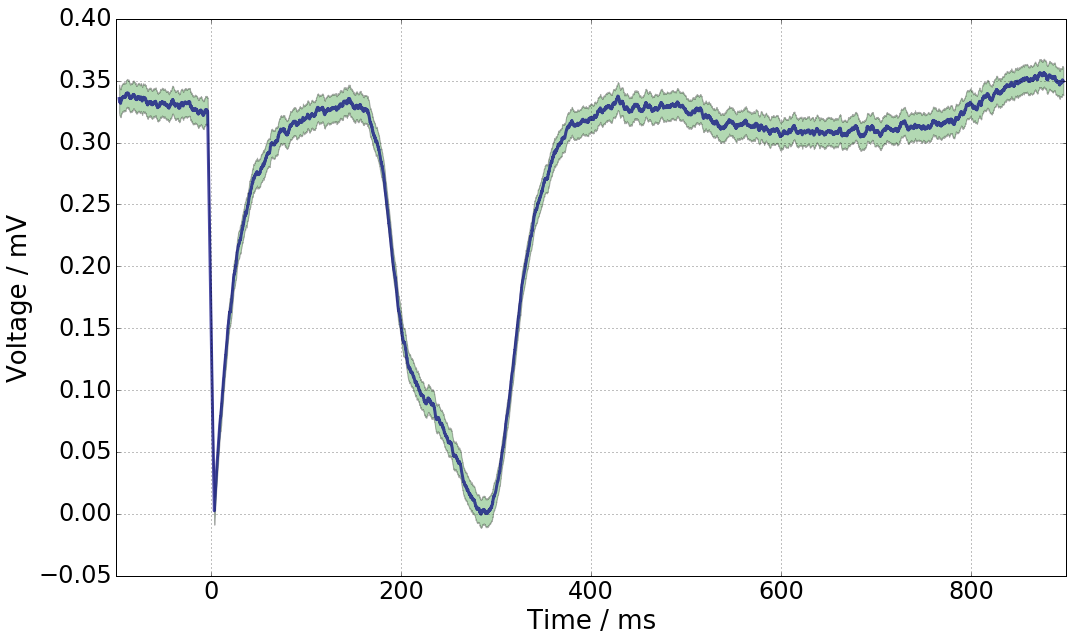

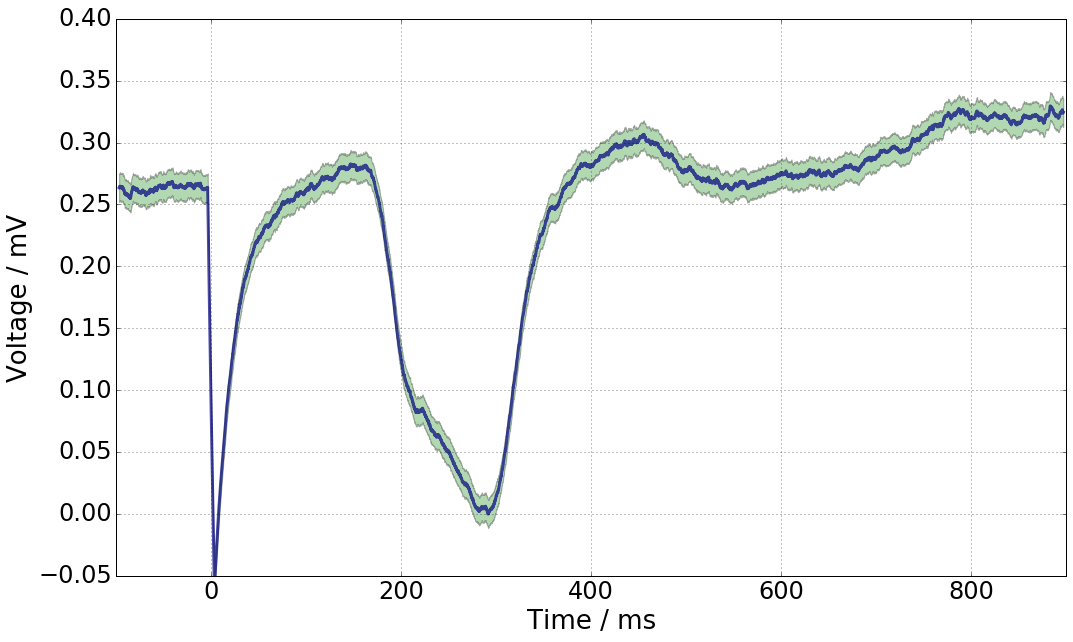

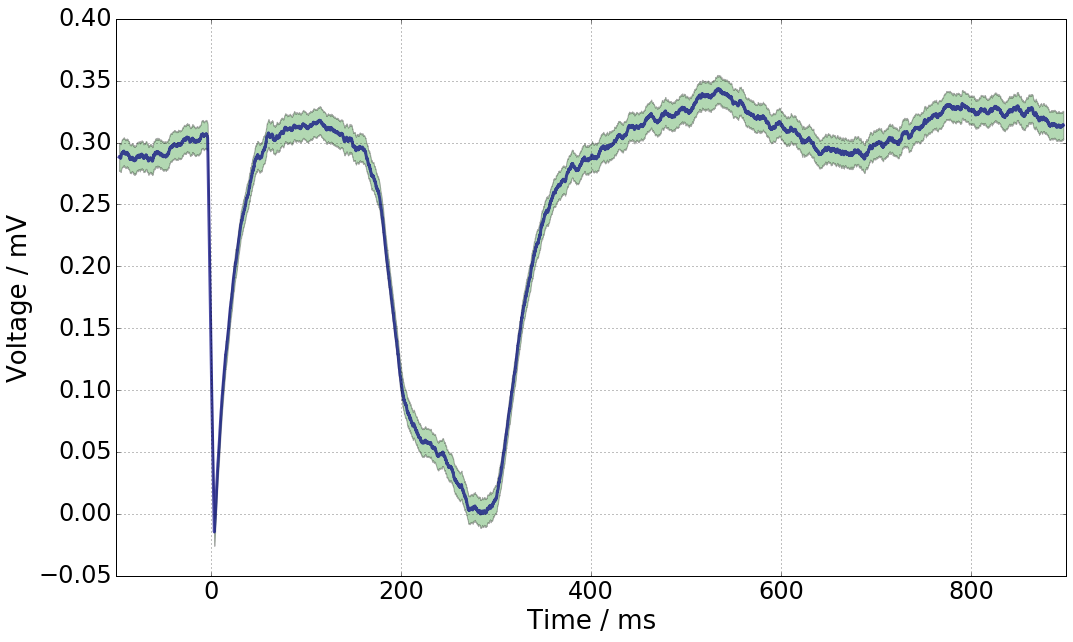

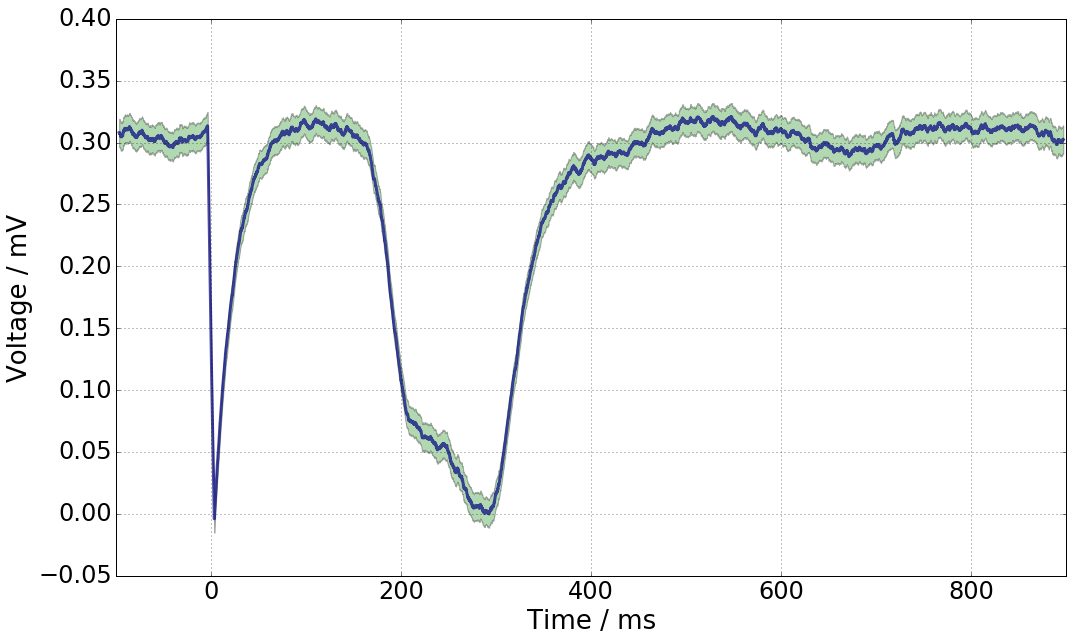

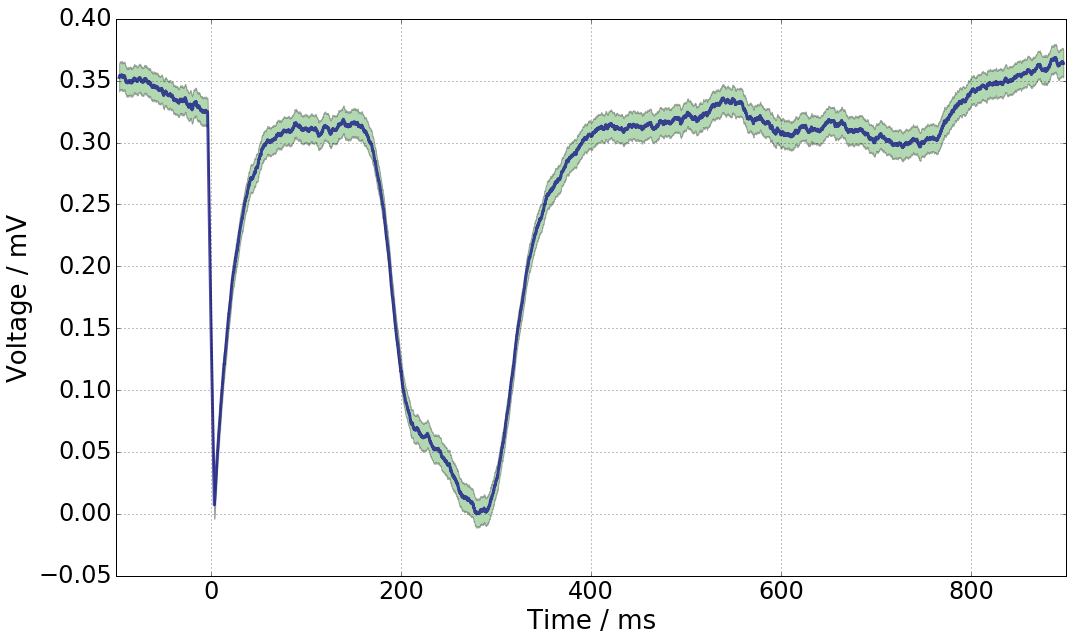

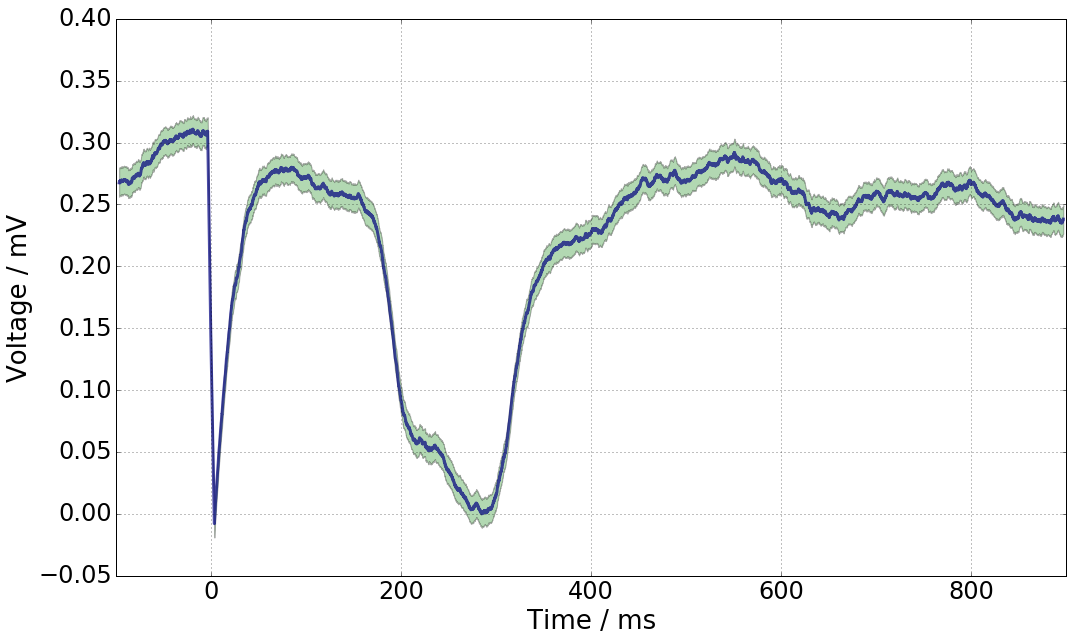

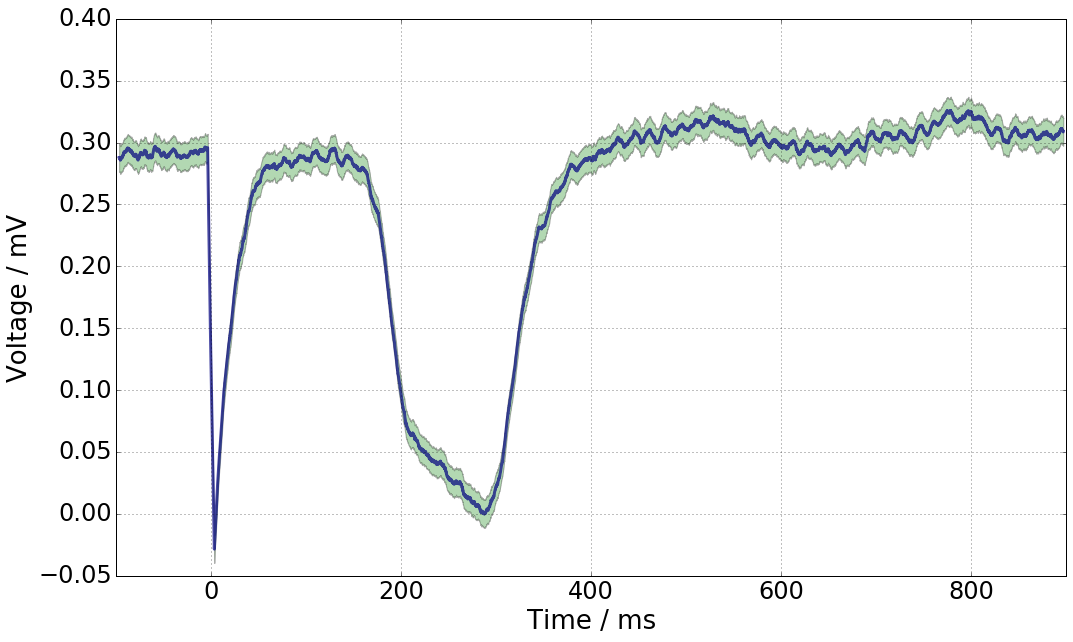

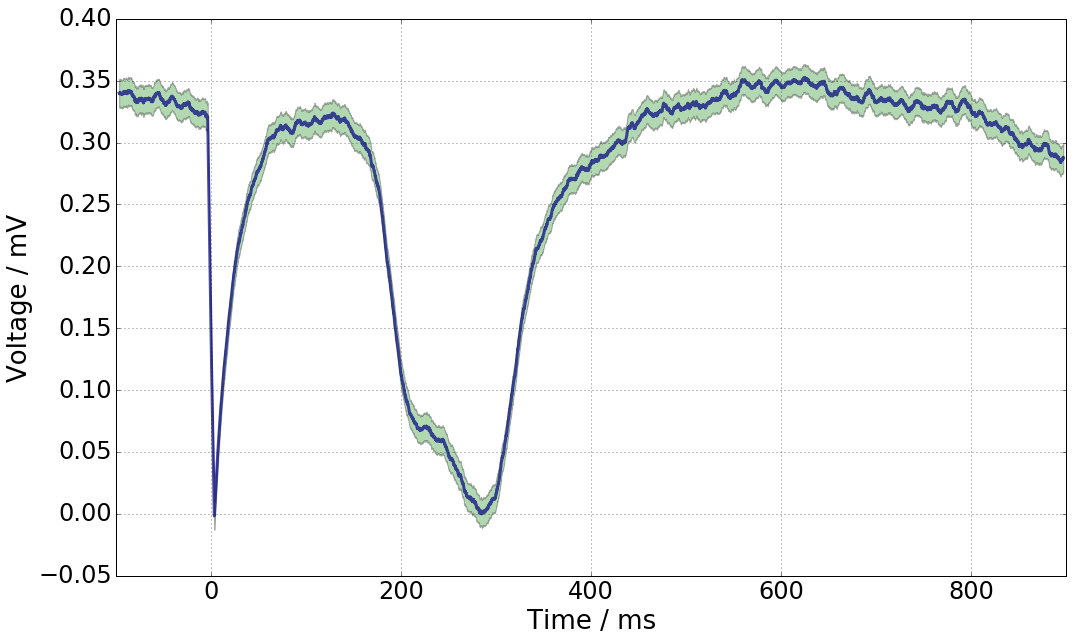

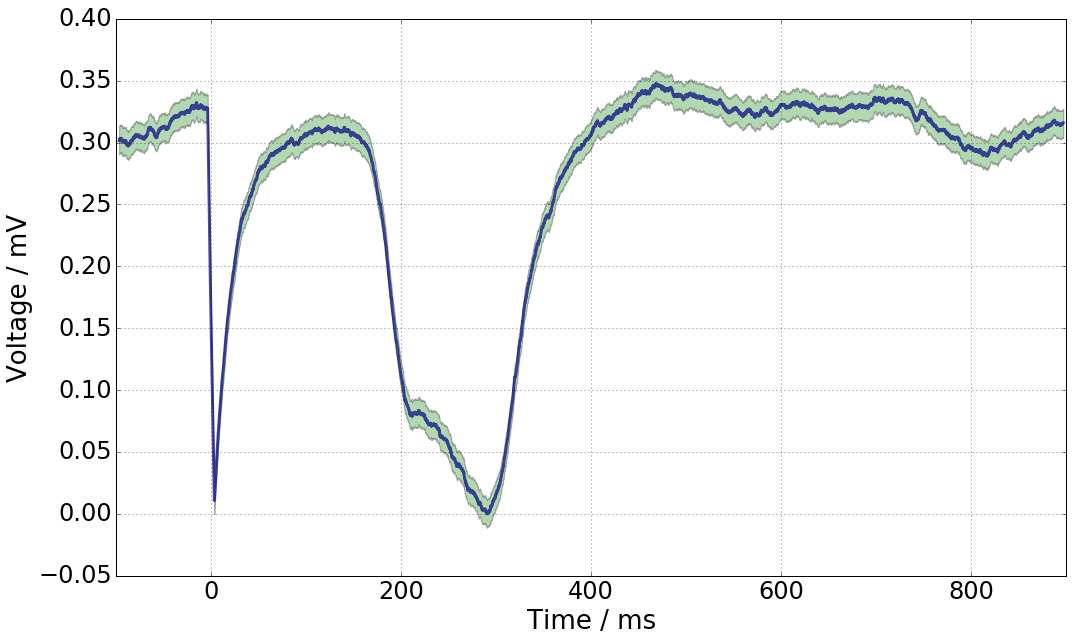

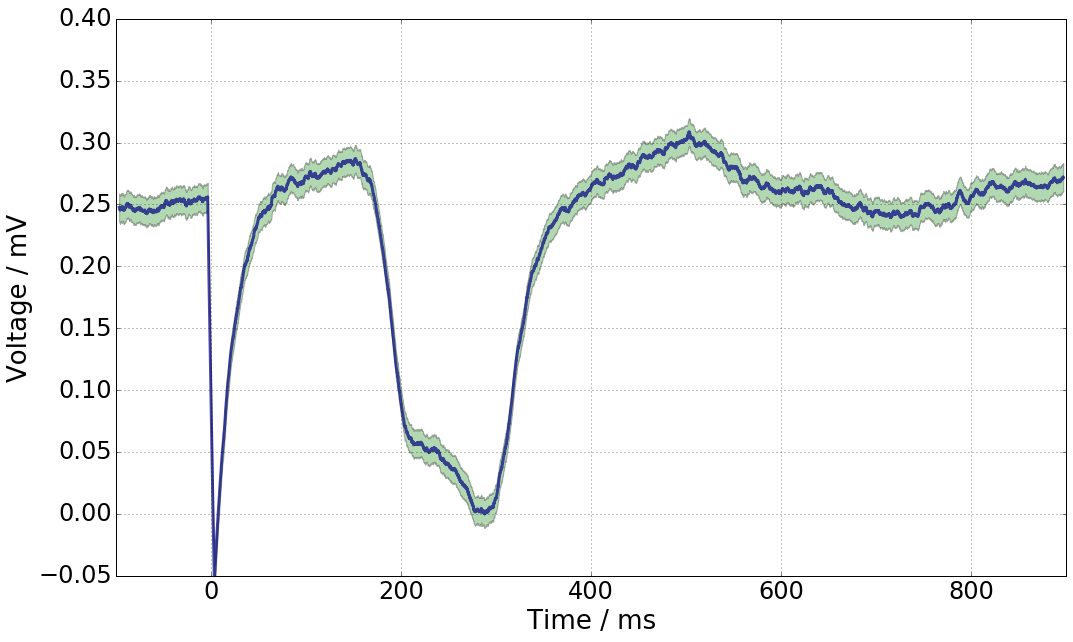

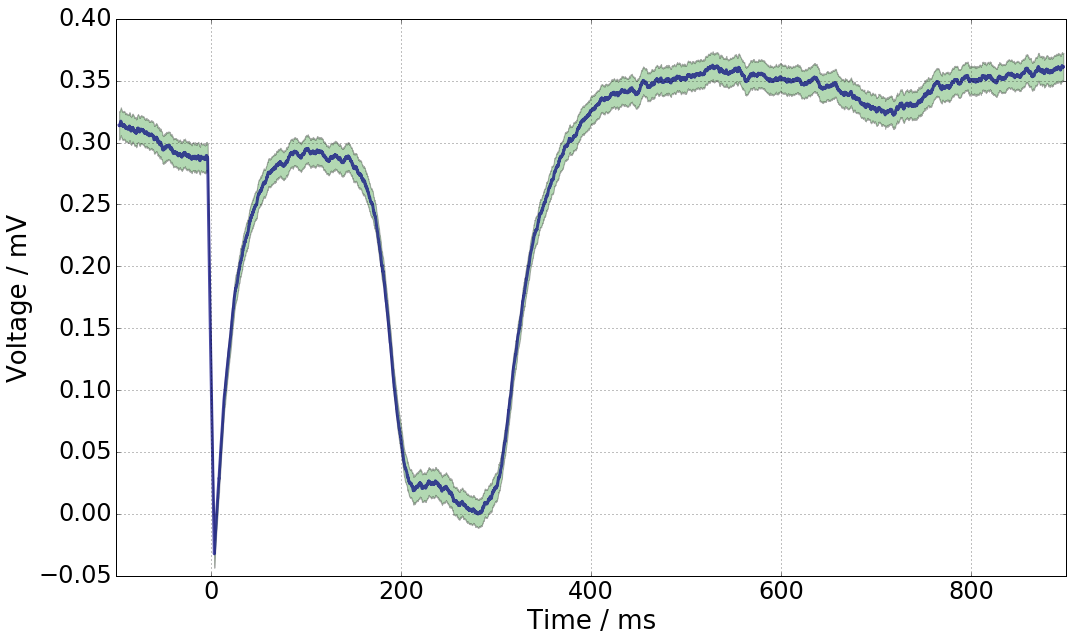

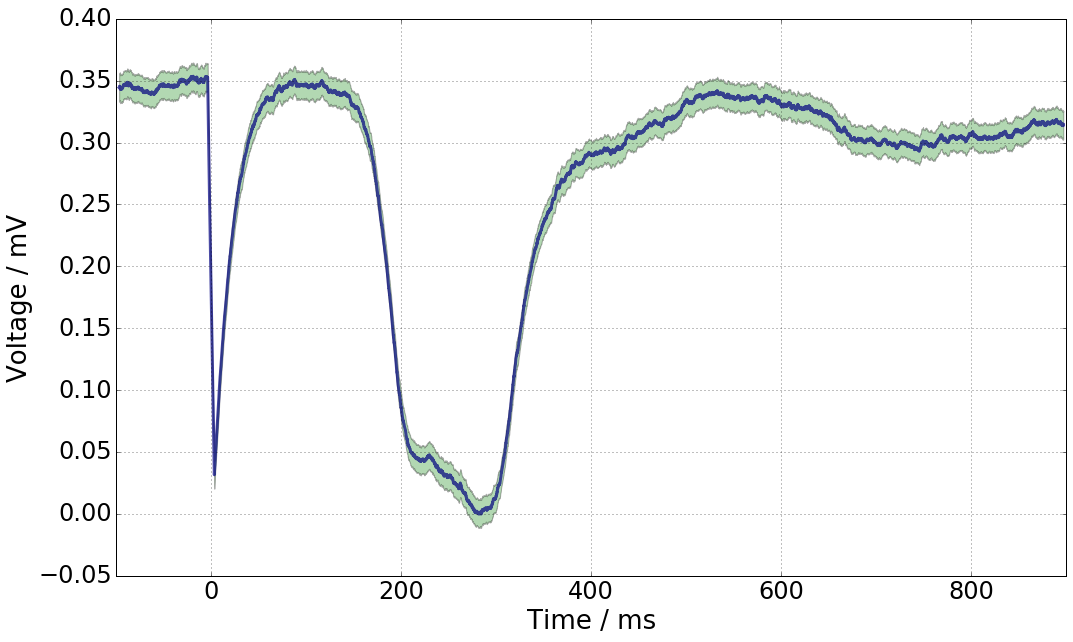

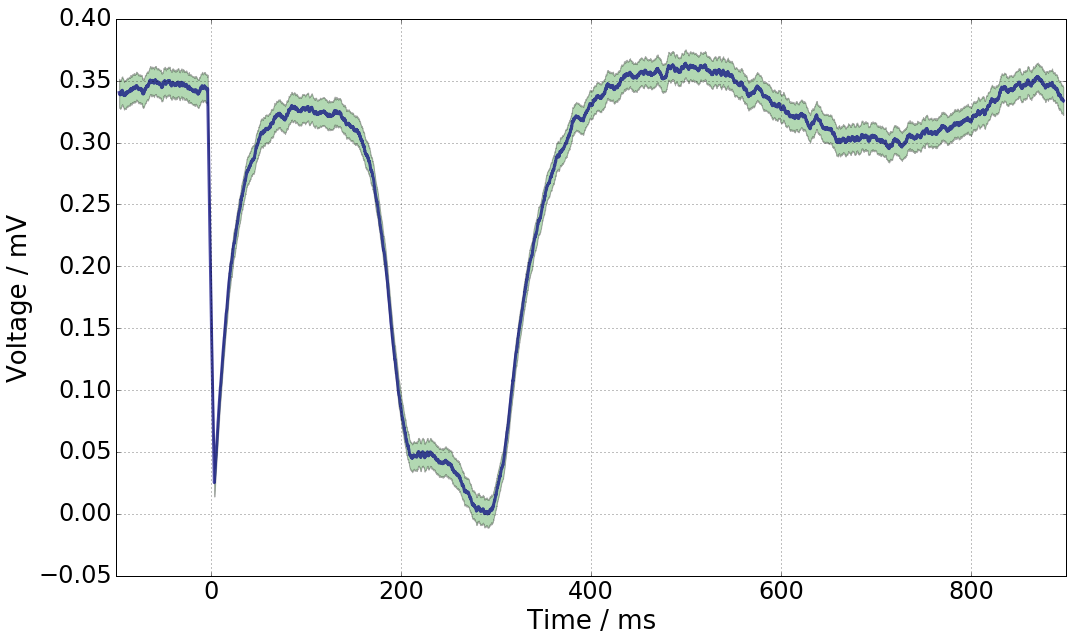

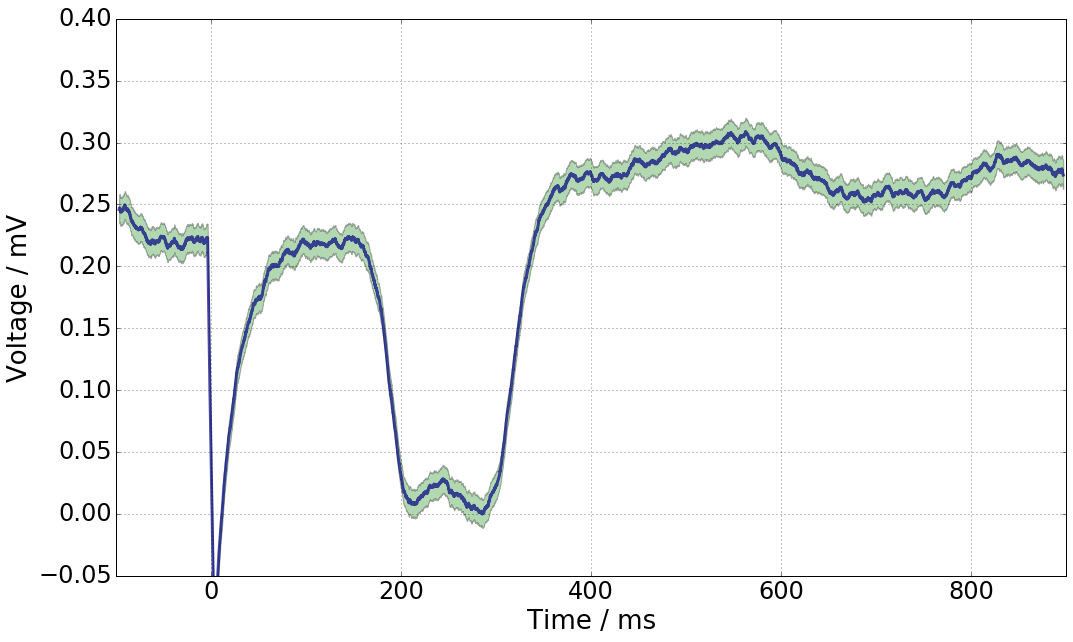

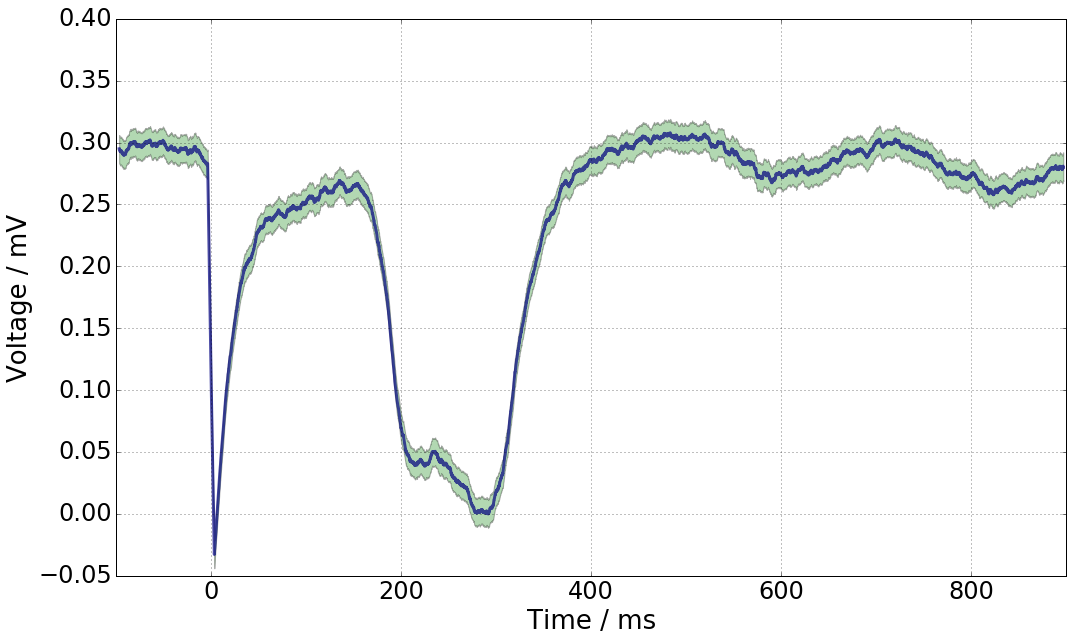

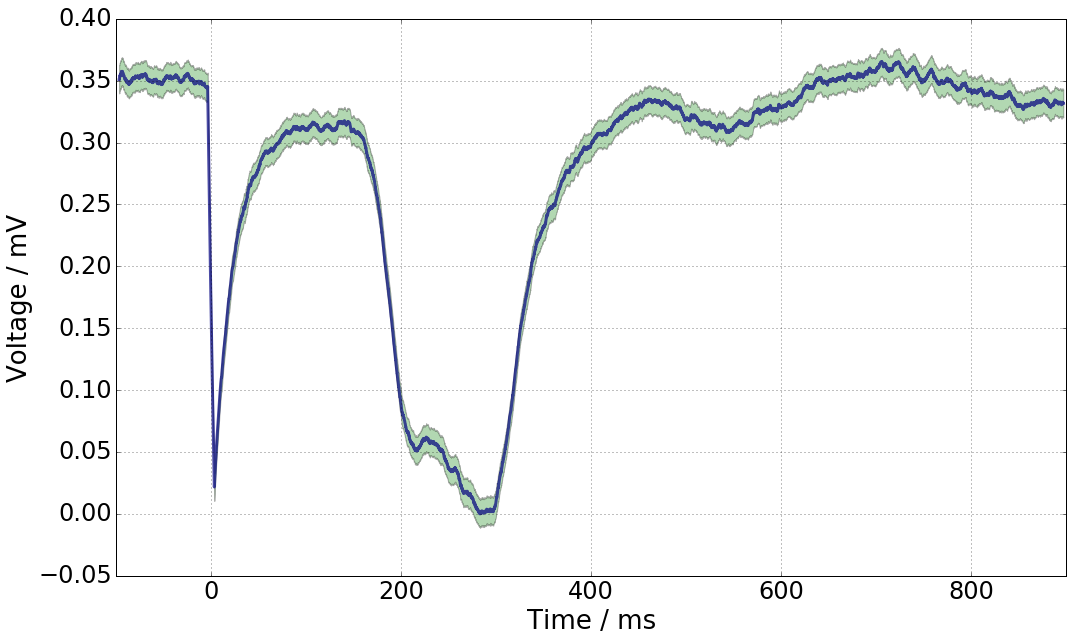

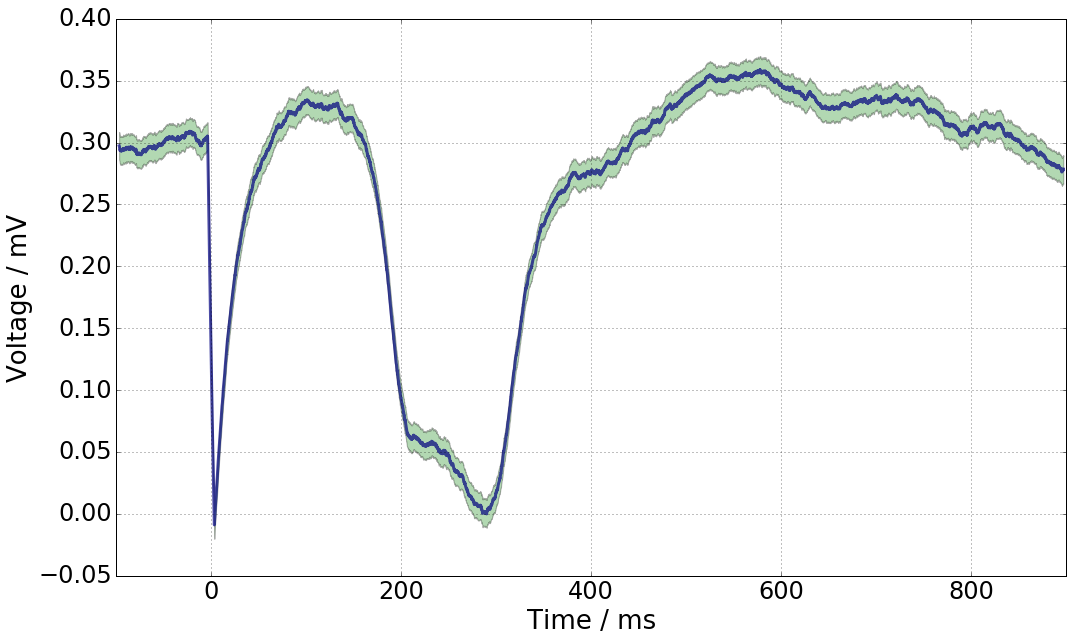

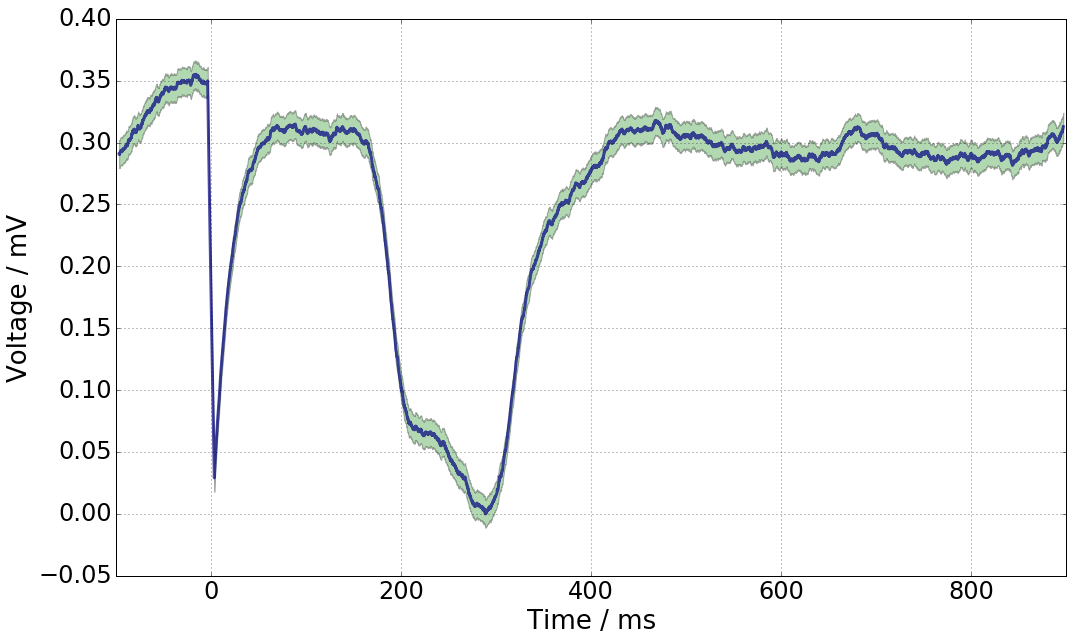

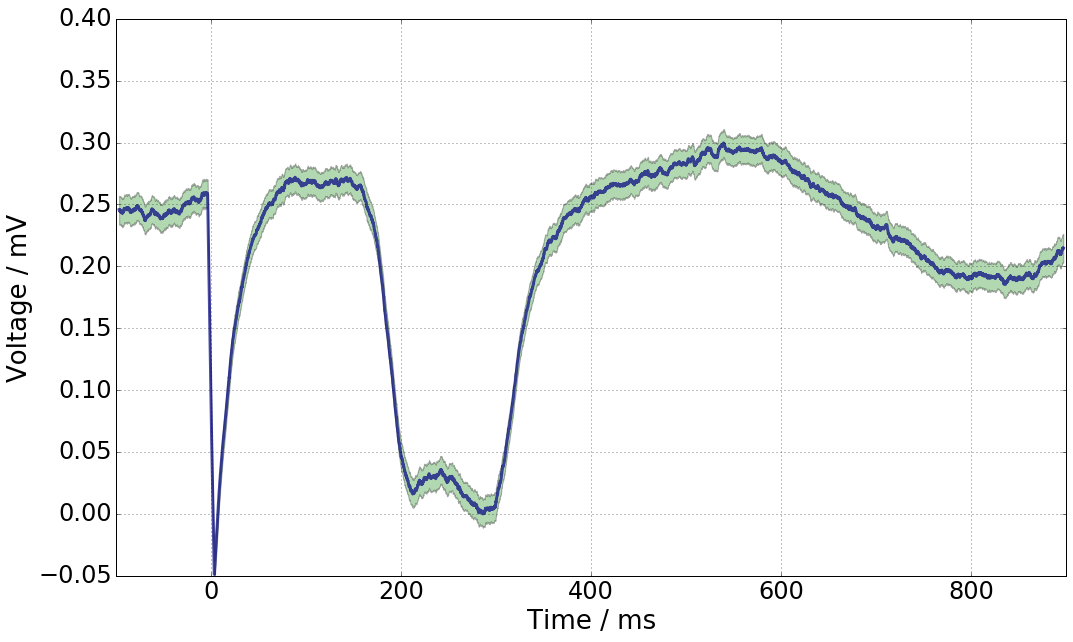

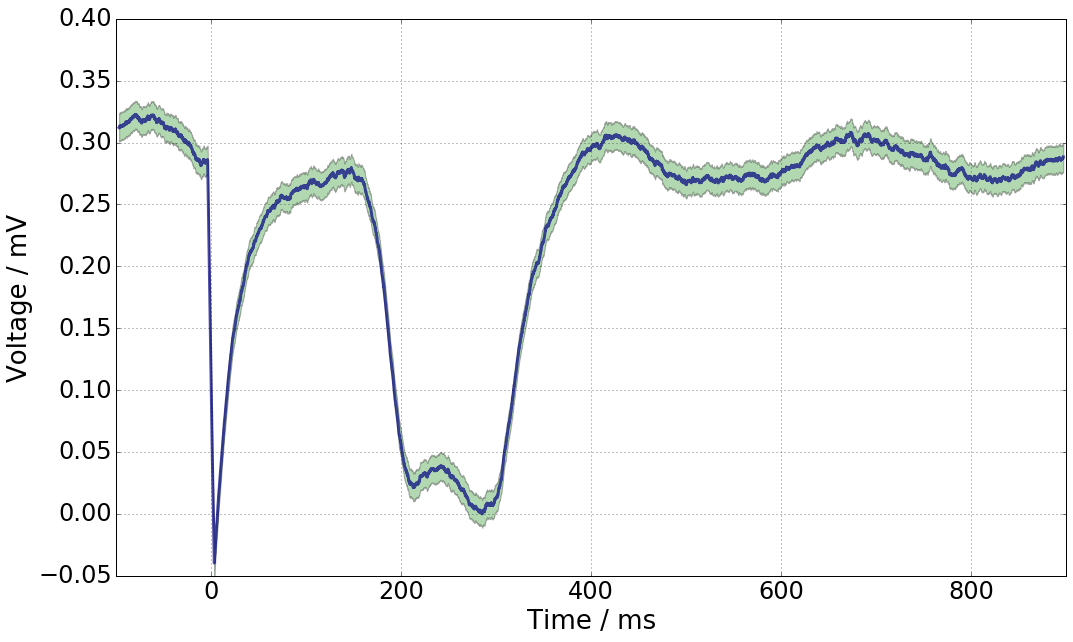

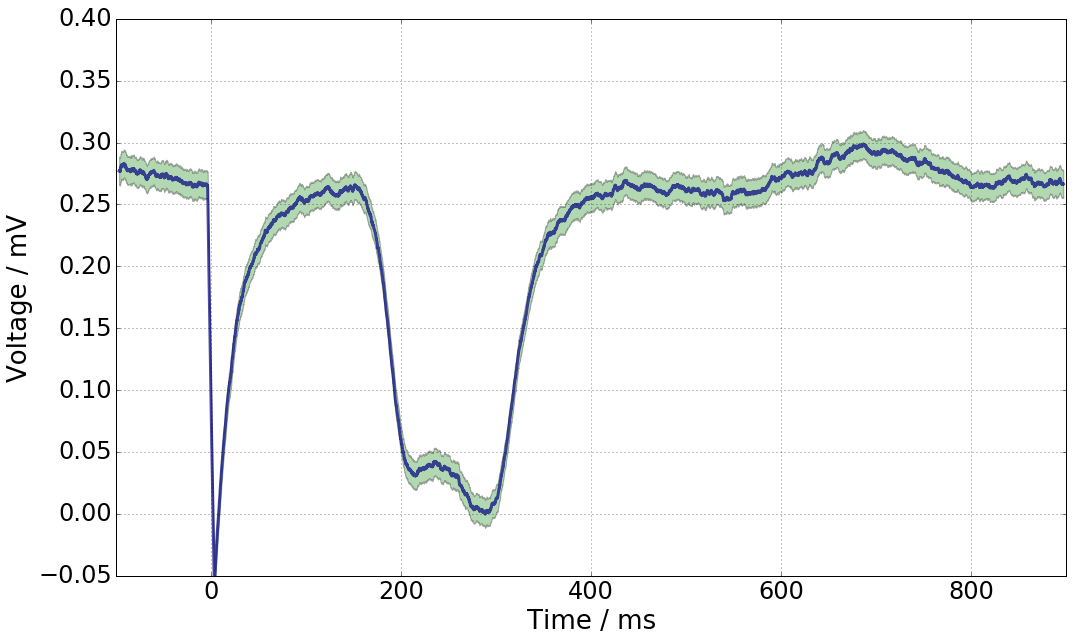

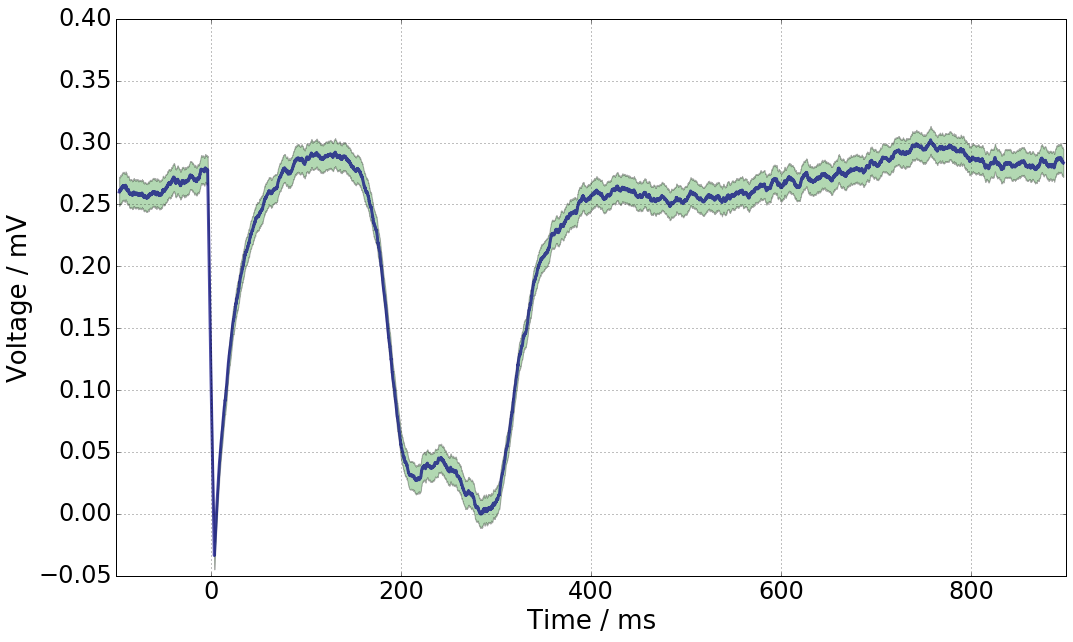

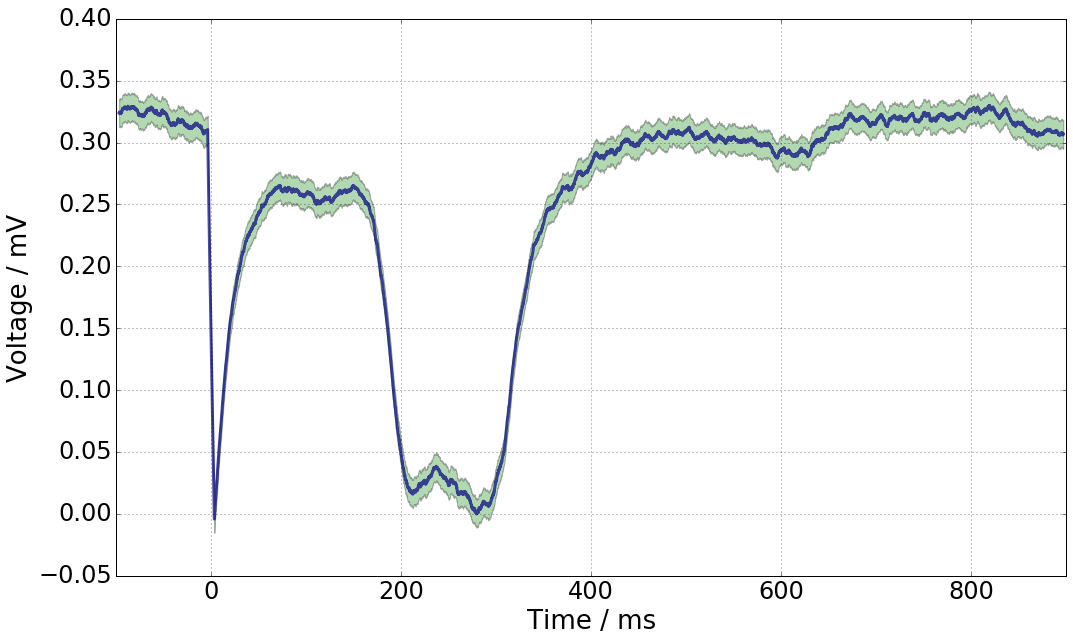

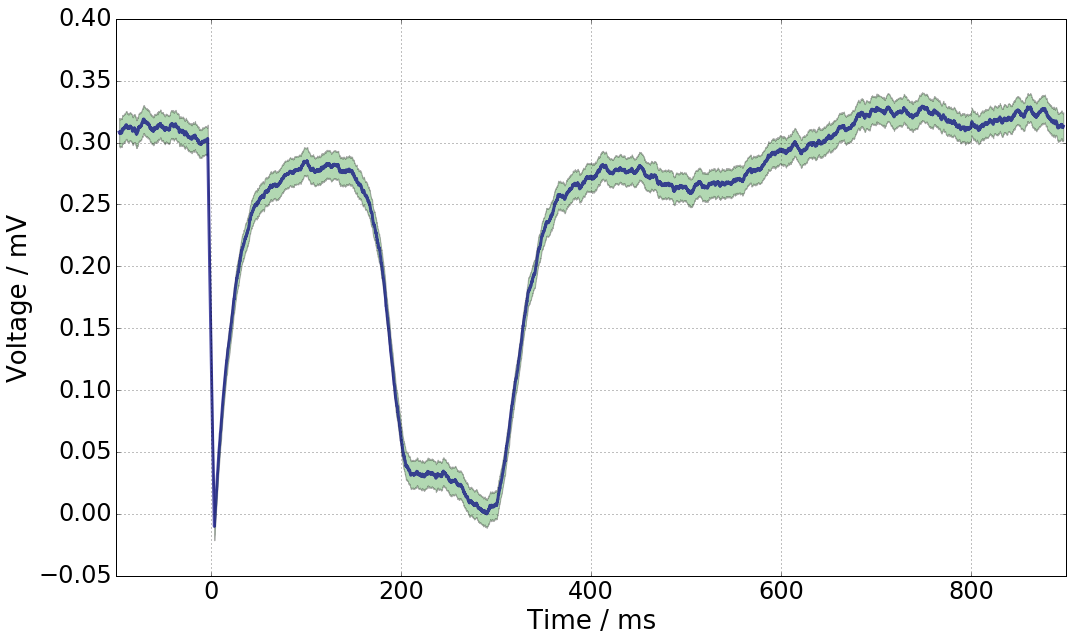

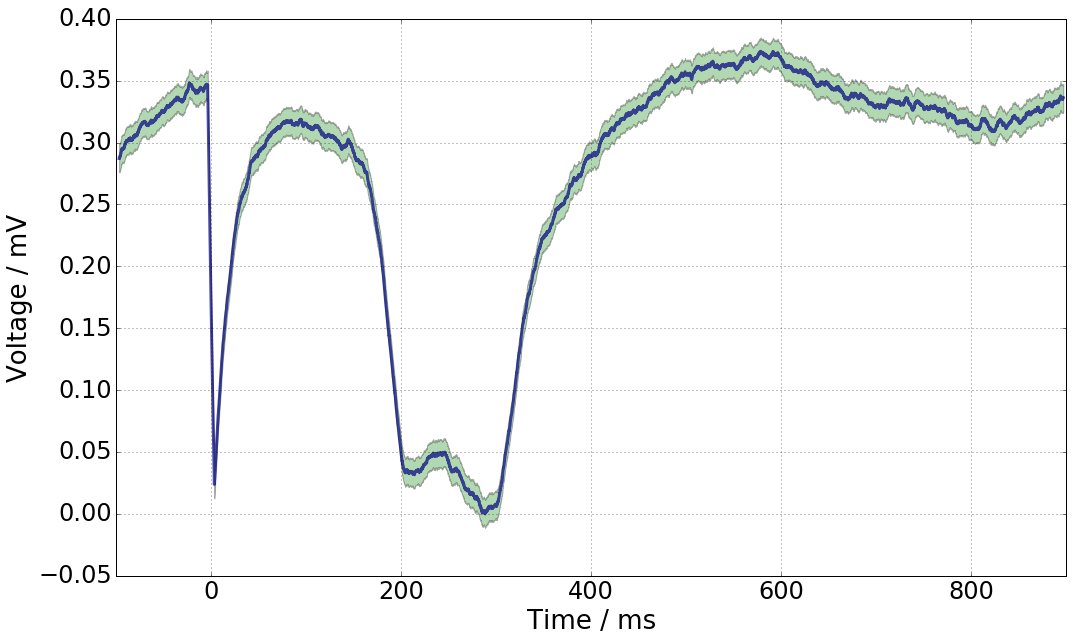

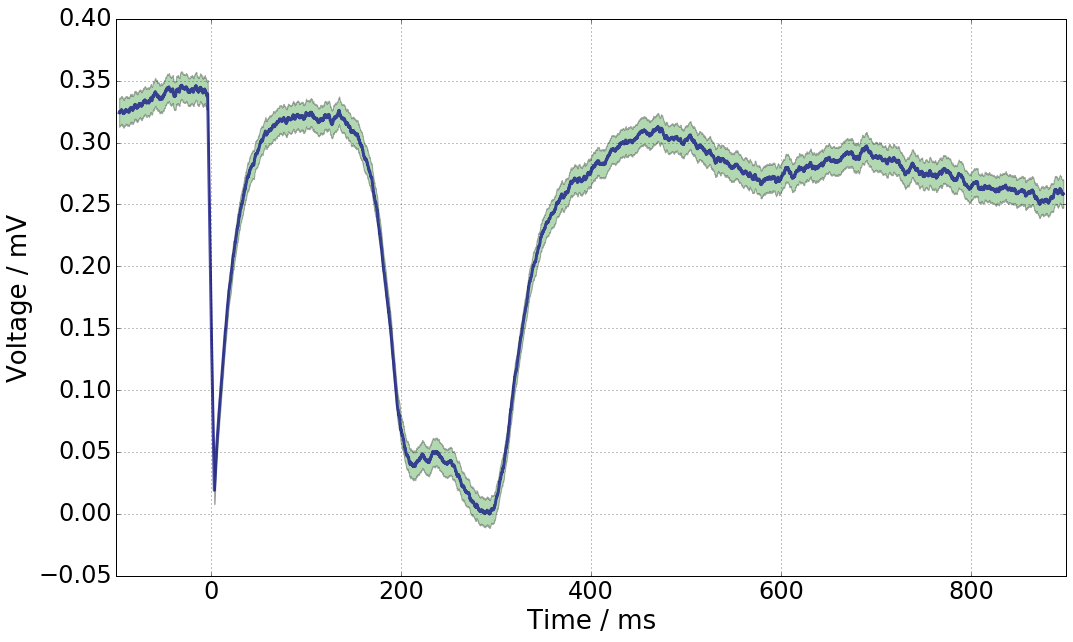

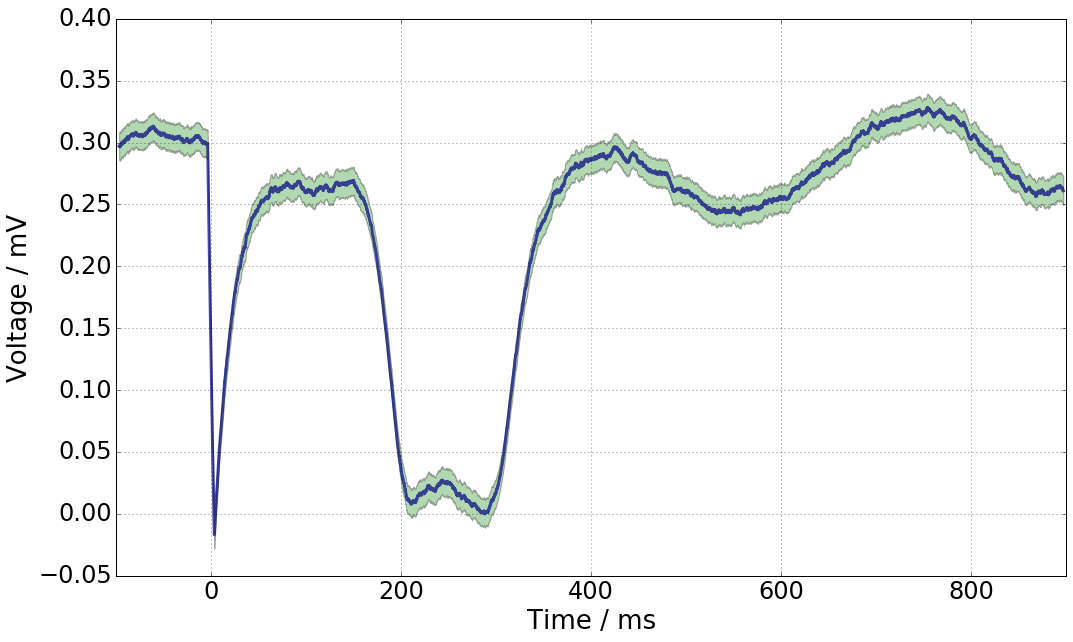

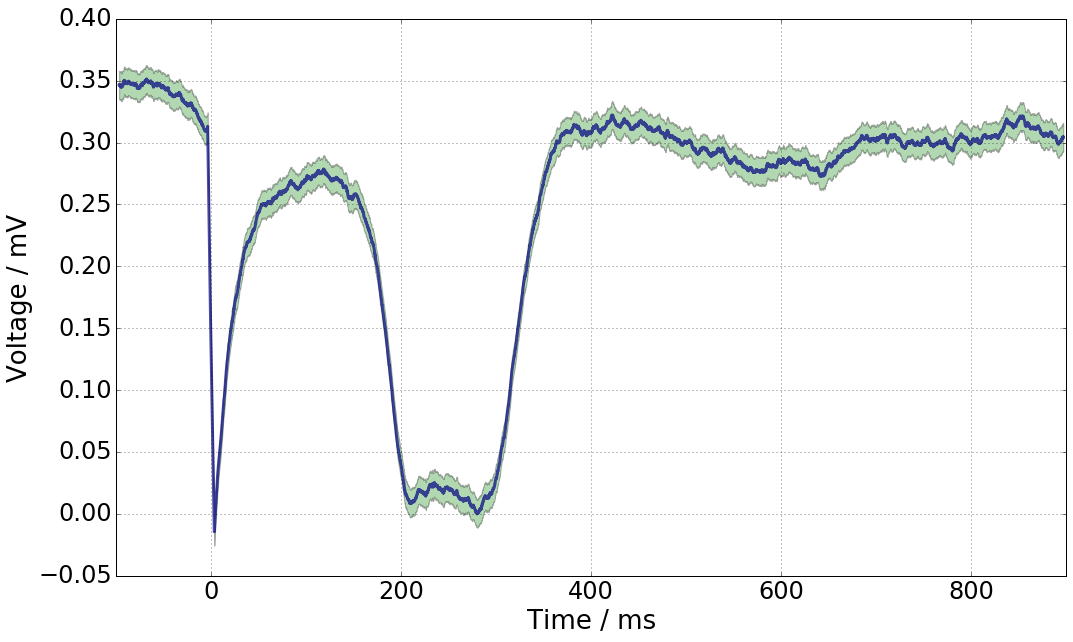

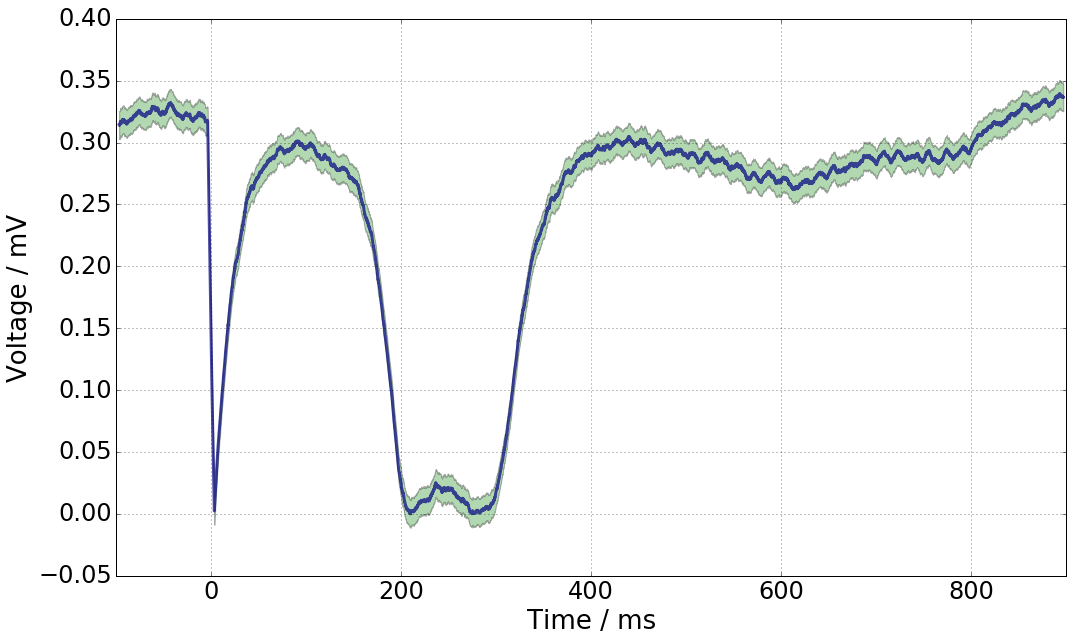

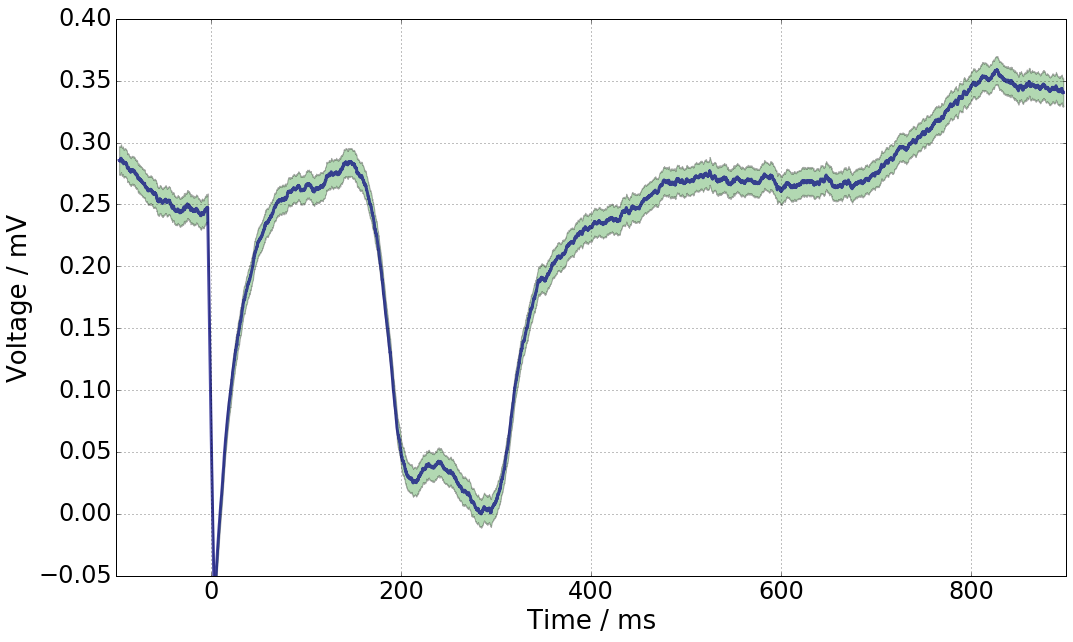

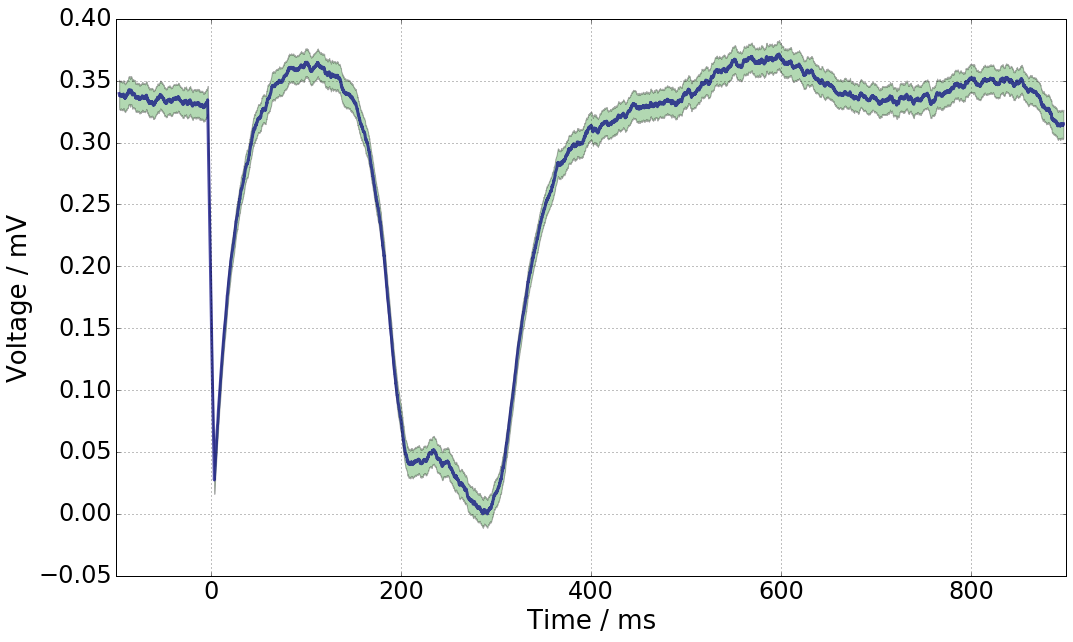

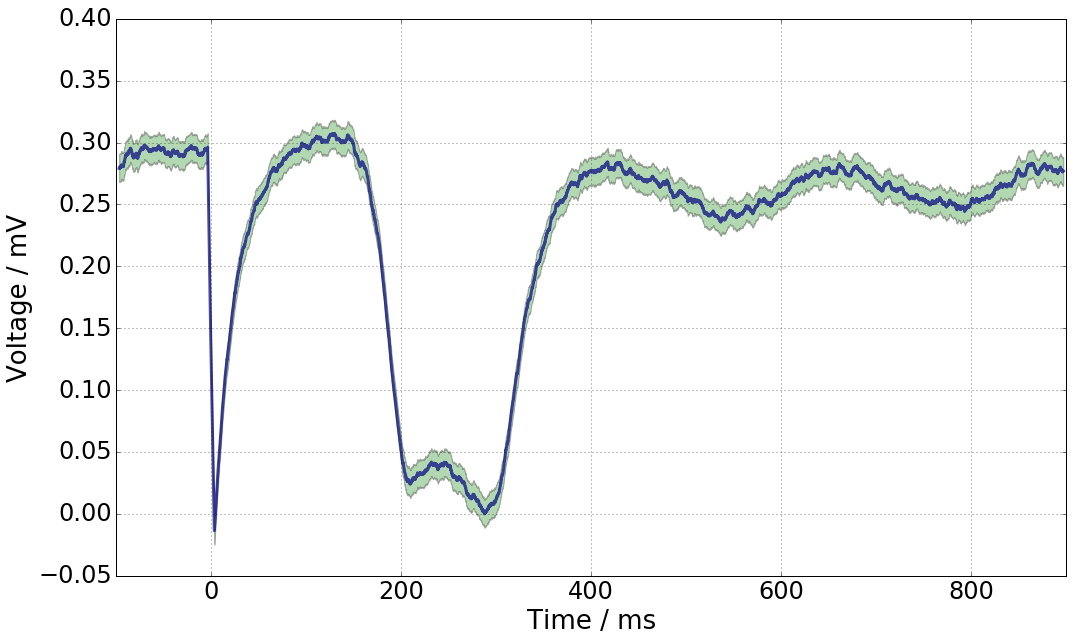

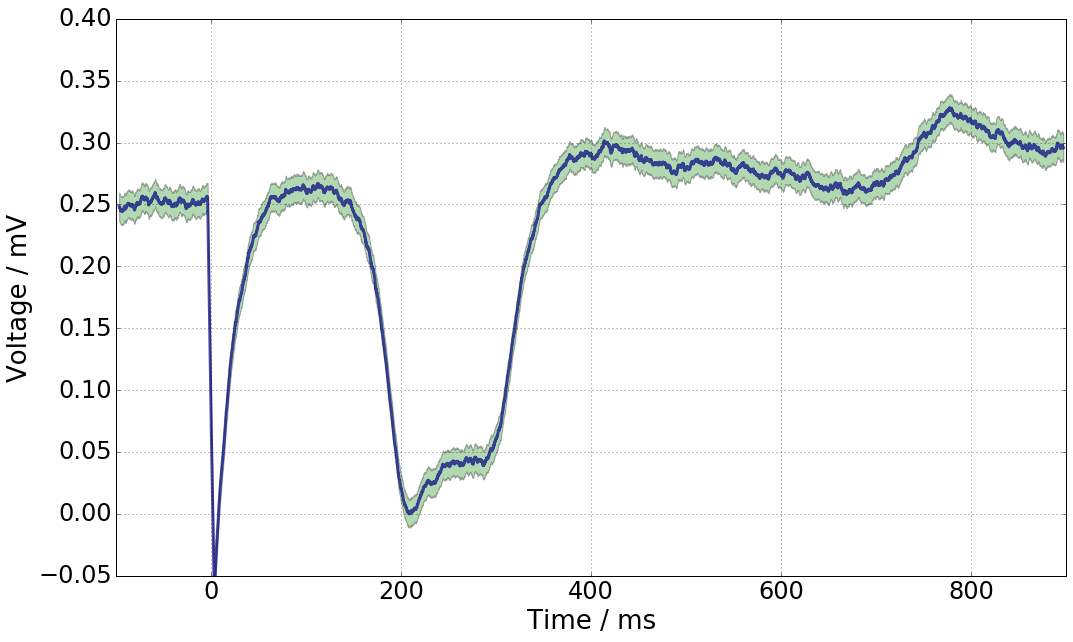

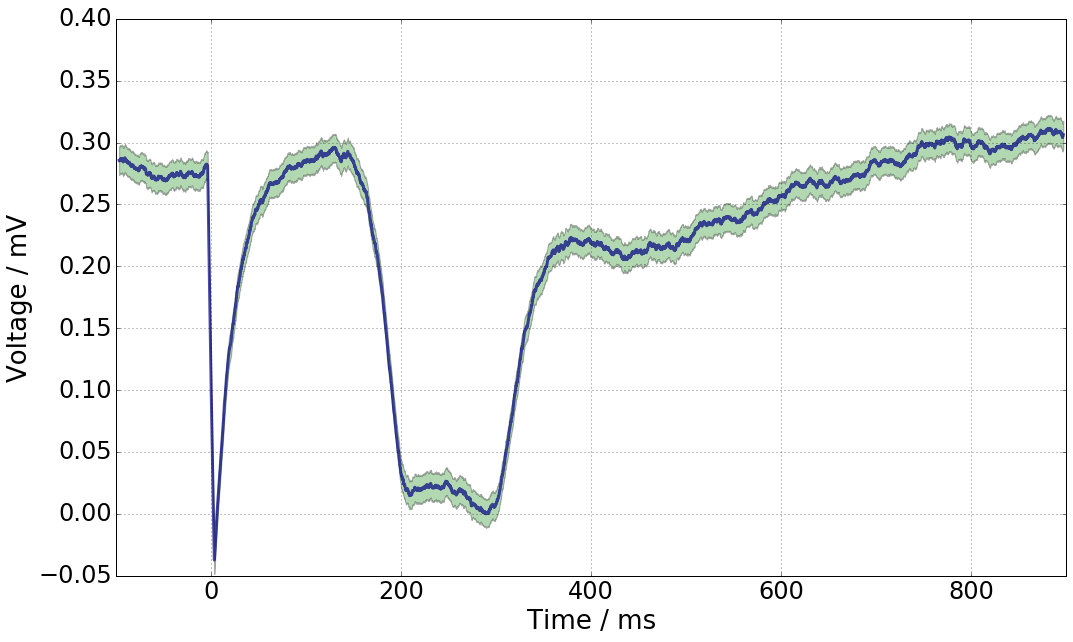

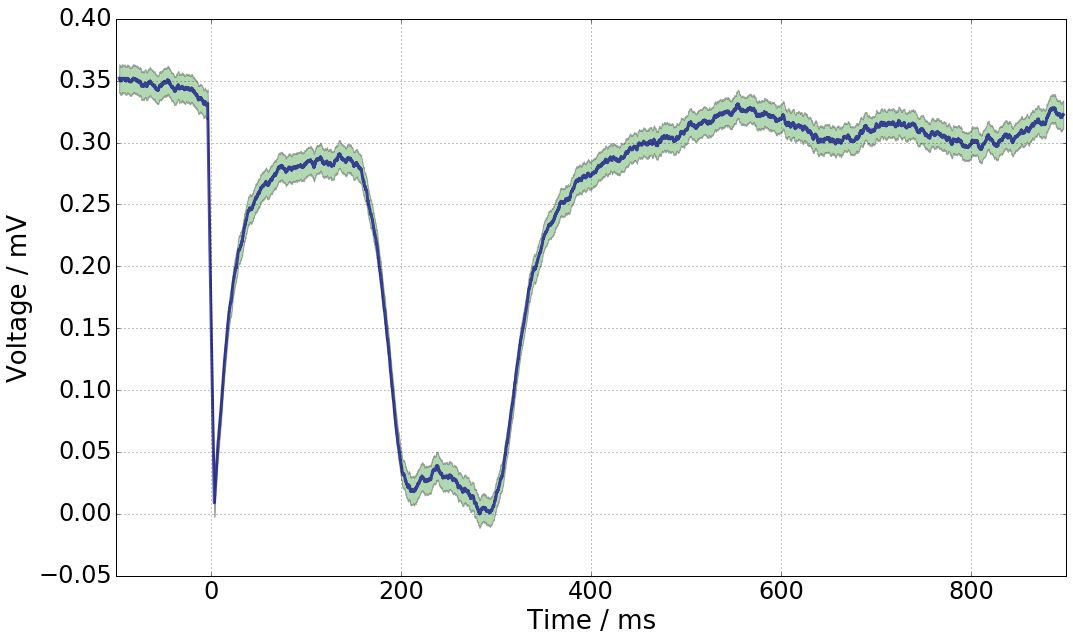

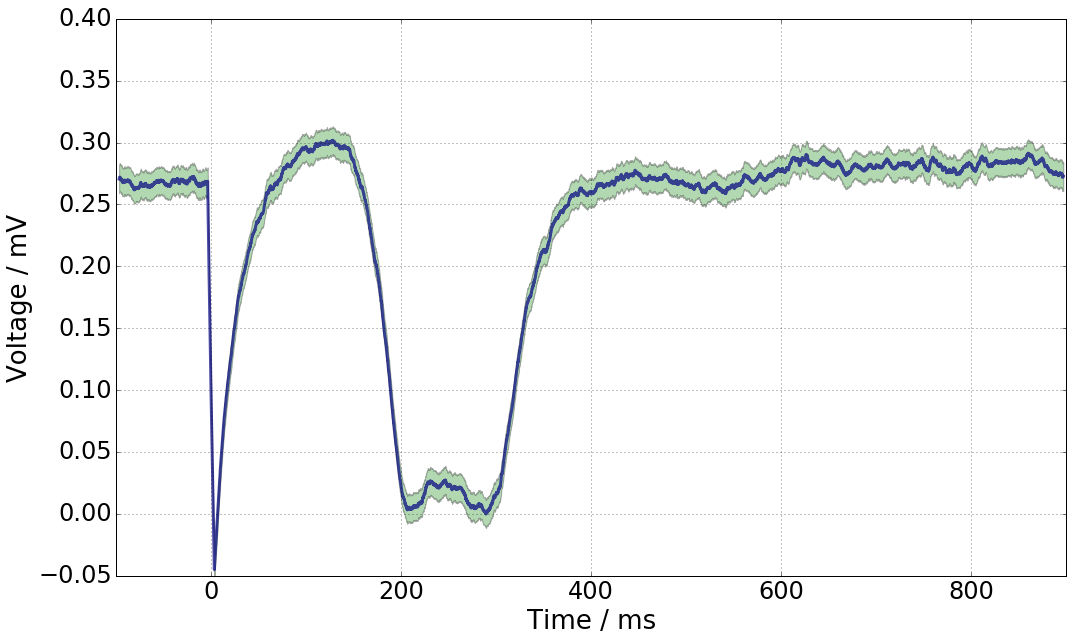

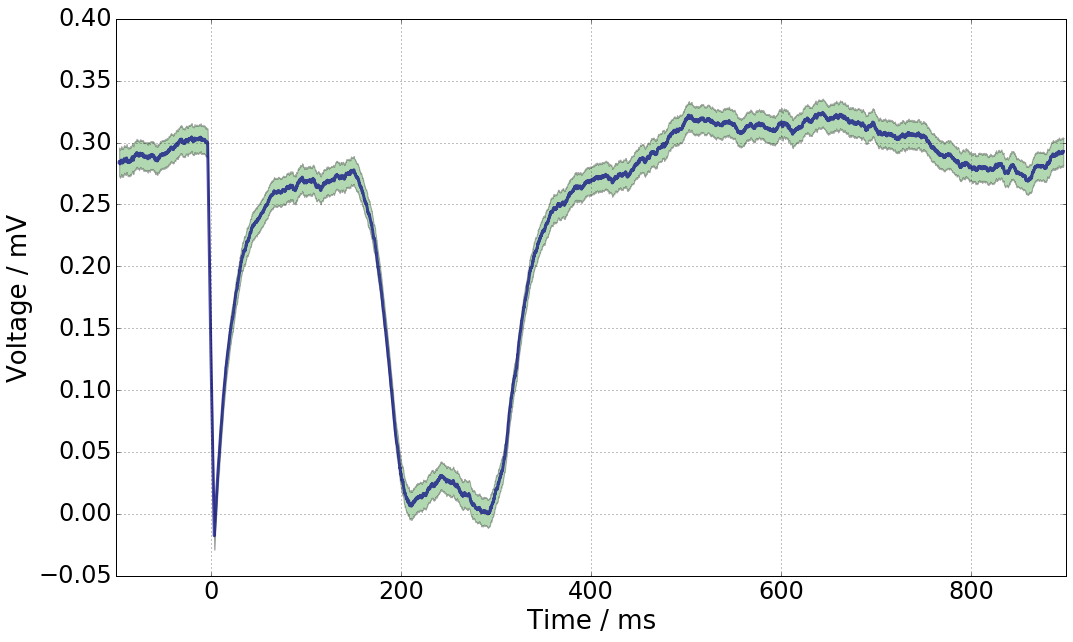

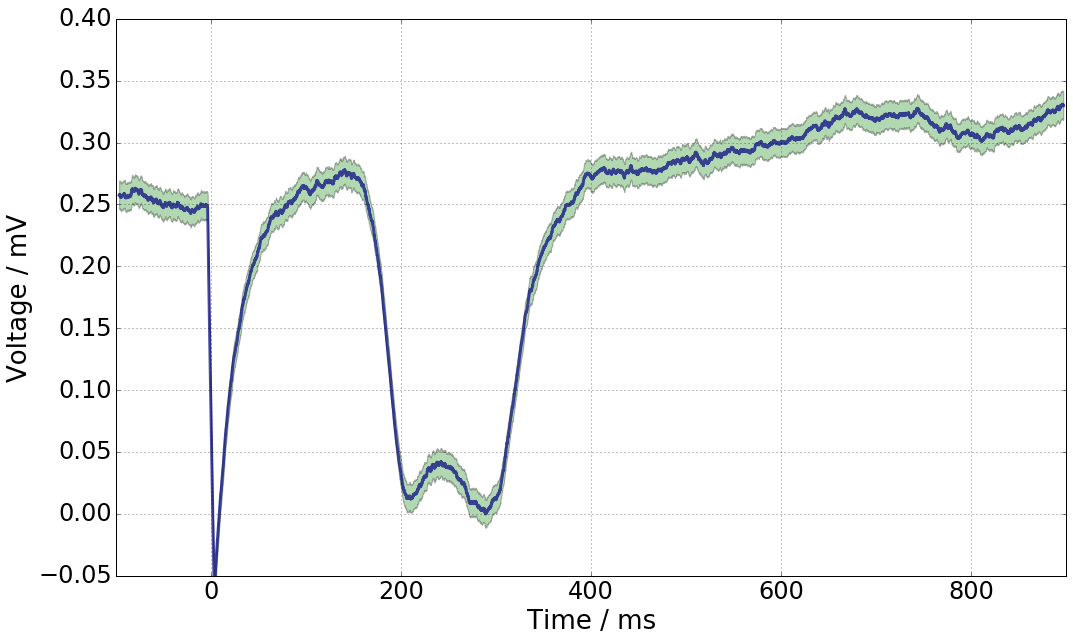

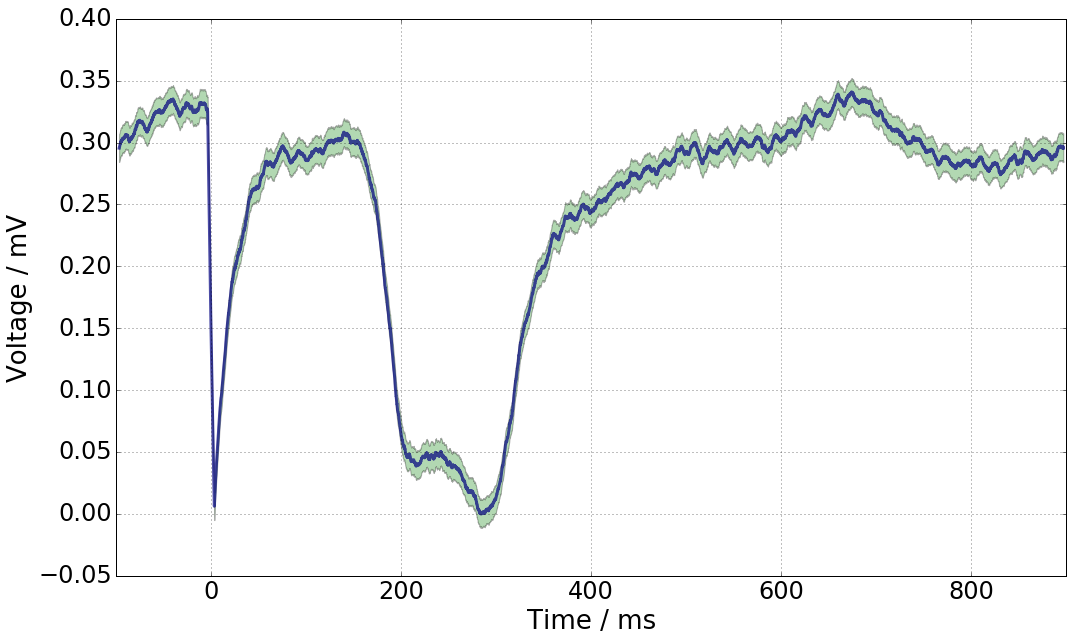

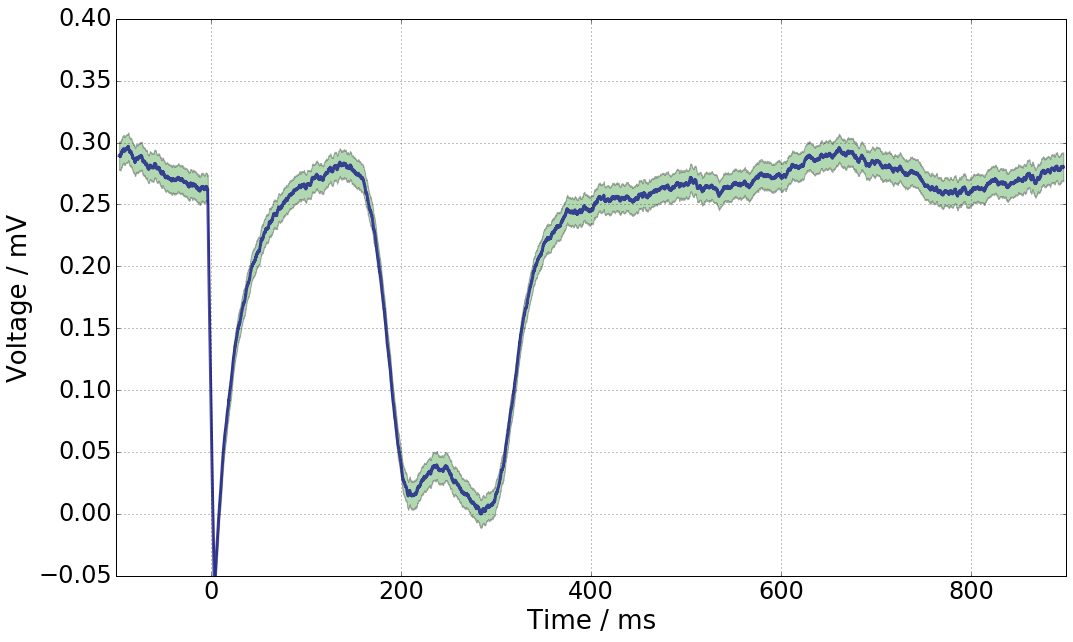

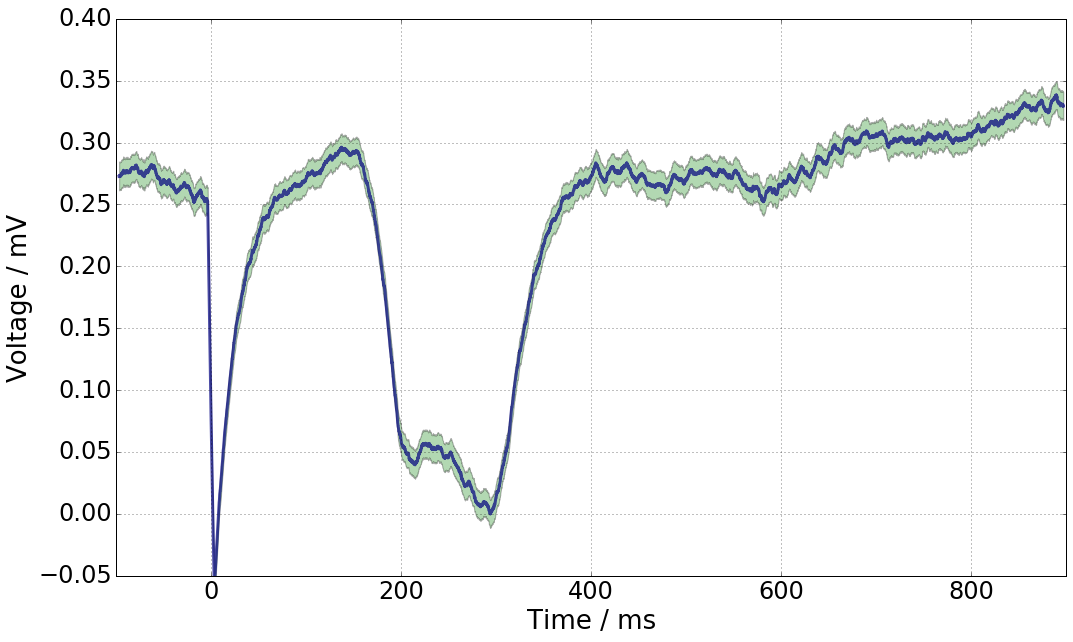

In [154]:
plt.figure(figsize=(15,9))

for q in range(0,len(Cfiles)):
#for q in range(0,1):

    plt.figure(figsize=(15,9))
    P=21
    PP=3
    XX = Xvals[q]
    YY = Yvals[q]
    
    plt.plot(XX,YY,label=(names[q]+''+'V/cm'),alpha=0.7,lw=3,color='navy')
    sigma = 0.011238097450219895
    y1 = YY-sigma
    y2 = YY+sigma
    plt.fill_between(XX, y1, y2, facecolor='green', interpolate=True,alpha=0.3)
    plt.xlim(-100,900)
    plt.ylim(-0.05,0.4)
    plt.xlabel(r'Time / ms',fontsize=26)
    plt.ylabel('Voltage / mV',fontsize=26)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.grid()
    #plt.legend(loc='lower right',fontsize=25)
    plt.tight_layout()
    PPath = Path+'Plots/'+names[q]+'.tif'
    plt.savefig(PPath)
    plt.show()

In [135]:
T1cut

(array([1965]),)

In [9]:
TriggerTime = find_nearest(Xvals[0],0)
Trigger     = np.where(Xvals[0]==TriggerTime)[0][0]
Cut = 2*Trigger


In [10]:
time,width = find_vals(Xvals[0],Yvals[0],Cut)
time

565.41007344975333

In [11]:
Velocity=[]
Efield =[]
FWHM  =[]
for q in range(0,len(files)):
    time,width = find_vals(Xvals[q],Yvals[q],Cut)
    V      = 20/(time*1e-3)
    Velocity.append(V)
    Efield.append(float(names[q]))
    FWHM.append(width)
Velocity = np.array(Velocity)
Efield = np.array(Efield)
FWHM = np.array(FWHM)

In [12]:
FWHM

array([ 228.41999423,  137.19999653,  114.8799971 ,   99.99999747,
         81.35999794,   74.05999813,   66.09999833])

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


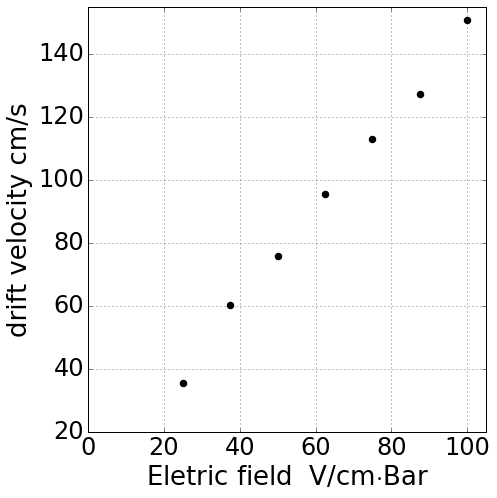

In [13]:
plt.figure(figsize=(7,7))
plt.scatter(Efield/2,Velocity,color='k',linewidth=3)

plt.xlim(0,105)
plt.ylim(20,155)
plt.xlabel(r'Eletric field  V/cm$\cdot$Bar',fontsize=26)
plt.ylabel(r'drift velocity cm/s',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=25)
plt.tight_layout()
#plt.savefig('BTX_ION_drift_ION_5-18-17-2.pdf')
plt.show()

In [16]:
vals = np.polyfit(Efield/2,Velocity,1)
np.poly1d(vals)[0]

1.7264611024940004

In [17]:
vals

array([ 1.47765616,  1.7264611 ])

In [15]:
np.polyfit?

In [ ]:
poly

In [ ]:
FWHM[0:6]

In [ ]:
x = np.log(Efield[1:6])
y = np.log(FWHM[1:6])
poly=np.polyfit(x,y,1)

In [ ]:
plt.plot(x,y,'o')
plt.plot(x,np.poly1d(poly)(x))

In [ ]:
poly

In [ ]:
np.poly1d?

In [ ]:
Efield, FWHM = zip(*sorted(zip(Efield, FWHM)))
Efield = np.array(Efield)
FWHM = np.array(FWHM)

In [ ]:
def ef(E,a):
    return a/(E)**(4/3)

popt,pcov = curve_fit(ef,Efield,FWHM)
popt
pcov

In [ ]:
def ef(E,a):
    return a/(E)**(4/3)

popt,pcov = curve_fit(ef,Efield,FWHM)

plt.figure(figsize=(7,7))
plt.scatter(Efield,FWHM,color='m',linewidth=3,label='data')
#plt.plot(Efield,ef(Efield,*popt),'r',label='fit')
x=np.arange(1,30,0.1)
plt.plot(np.exp(x),np.exp(np.poly1d(poly)(x)))

#vars=np.logspace(1,3,10)
#plt.plot(vars,10**np.poly1d(poly)(np.log(vars)))
plt.xlabel(r'Eletric field  V/cm',fontsize=26)
plt.ylabel(r'pulse FWHM ms',fontsize=26)
plt.xlim(10,1000)
plt.ylim(50,300)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xticks(np.arange(50, 210, 25))
plt.loglog()
plt.legend(loc="upper right",fontsize=24)
plt.show()